In [1]:
import os, sys, re
from functools import partial

import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import shap

import dproc, sgml, sgutil

print(sys.version)
for i in [scipy, sklearn, mpl, sns, np, pd, pl, cb, lgb, xgb, shap]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
scipy 1.14.0
sklearn 1.5.1
matplotlib 3.9.1.post1
seaborn 0.13.2
numpy 1.26.4
pandas 2.2.2
polars 1.17.1
catboost 1.2.7
lightgbm 4.5.0
xgboost 2.1.1
shap 0.46.0


# Data acquirement

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'org.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['var_pkl'])):
    !kaggle competitions download -c playground-series-s4e12
    !mkdir data
    !unzip playground-series-s4e12.zip -d data
    !rm playground-series-s4e12.zip
    !kaggle datasets download -d schran/insurance-premium-prediction
    !unzip insurance-premium-prediction.zip
    !mv "Insurance Premium Prediction Dataset.csv" "data/org.csv"
    !rm insurance-premium-prediction.zip

In [3]:
if not os.path.exists(files['var_pkl']):
    features = \
"""1. Age: Age of the insured individual (Numerical)
2. Gender: Gender of the insured individual (Categorical: Male, Female)
3. Annual Income: Annual income of the insured individual (Numerical, skewed)
4. Marital Status: Marital status of the insured individual (Categorical: Single, Married, Divorced)
5. Number of Dependents: Number of dependents (Numerical, with missing values)
6. Education Level: Highest education level attained (Categorical: High School, Bachelor's, Master's, PhD)
7. Occupation: Occupation of the insured individual (Categorical: Employed, Self-Employed, Unemployed)
8. Health Score: A score representing the health status (Numerical, skewed)
9. Location: Type of location (Categorical: Urban, Suburban, Rural)
10. Policy Type: Type of insurance policy (Categorical: Basic, Comprehensive, Premium)
11. Previous Claims: Number of previous claims made (Numerical, with outliers)
12. Vehicle Age: Age of the vehicle insured (Numerical)
13. Credit Score: Credit score of the insured individual (Numerical, with missing values)
14. Insurance Duration: Duration of the insurance policy (Numerical, in years)
15. Premium Amount: Target variable representing the insurance premium amount (Numerical, skewed)
16. Policy Start Date: Start date of the insurance policy (Text, improperly formatted)
17. Customer Feedback: Short feedback comments from customers (Text)
18. Smoking Status: Smoking status of the insured individual (Categorical: Yes, No)
19. Exercise Frequency: Frequency of exercise (Categorical: Daily, Weekly, Monthly, Rarely)
20. Property Type: Type of property owned (Categorical: House, Apartment, Condo)"""
    df_var = pd.DataFrame(
        [pd.Series(re.findall("[0-9]+. (?P<name>[^:]+): (?P<desc>.+)", i)[0], index=['name', 'Description']) for i in features.split('\n') if len(i) != 0],
    ).set_index('name')
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test', 'org']
    ])
    pl_type = dproc.get_type_pl(
        df_type, 
        {
            'Smoking Status': pl.Categorical, 'Gender': pl.Categorical, 'Marital Status': pl.Categorical, 'Education Level': pl.Categorical,
            'Occupation': pl.Categorical, 'Location': pl.Categorical, 'Policy Type': pl.Categorical, 'Smoking Status': pl.Categorical,
            'Exercise Frequency': pl.Categorical, 'Property Type': pl.Categorical
        }
    )
    df_var = pd.concat([
        df_var,
        df_type,
        pd.Series(pl_type, name = 'pl_type')
    ], axis=1)
    df_var
    pl.scan_csv('data/train.csv', schema_overrides = pl_type).sink_parquet(files['train_parquet'])
    pl.scan_csv('data/test.csv', schema_overrides = pl_type).sink_parquet(files['test_parquet'])
    pl.scan_csv('data/org.csv', schema_overrides = pl_type).sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
    !rm data/train.csv
    !rm data/test.csv
    !rm data/org.csv
df_var = pd.read_pickle(files['var_pkl'])
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['org_parquet'])

In [5]:
ord_list = [
    ('Education Level', {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}),
    ('Location', {"Rural": 0, "Suburban": 1, "Urban": 2}),
    ('Policy Type', {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}),
    ('Exercise Frequency', {'Daily': 0, 'Weekly': 1, 'Monthly': 2, 'Rarely': 3}),
    ('Customer Feedback', {'Poor': 0, 'Average': 1, 'Good': 2}),
]

proc_list=[
    (i, pl.col(i).cast(pl.String).replace(d).cast(pl.Int8), ['{}: {}'.format(k, v) for k, v in d.items()])
    for i, d in ord_list 
]
proc_list += [
    ('Smoking Status', (pl.col('Smoking Status') == 'Yes').cast(pl.Int8), '0: No, 1: Yes'),
    ('Gender', (pl.col('Gender') == 'Male').cast(pl.Int8), '0: Female, 1: Male')
]

In [6]:
df_train, df_var_proc = dproc.apply_with_columns(df_train, proc_list, 'org')
df_var = pd.concat([
    df_var,
    df_var_proc
], axis = 0).assign(
    src = lambda x: x['src'].fillna('org')
).groupby(level=0).last()
df_test = dproc.apply_with_columns(df_test, proc_list)
df_org = dproc.apply_with_columns(df_org, proc_list)

df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas()

pd_vars= dproc.PD_Vars.load_or_create(os.path.join('data', 'vars') , df_var)

In [7]:
X_bool = ['Gender', 'Smoking Status']
X_ord = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Customer Feedback', 'Weekday', 'Day', 'Year', 'Month']
X_nom = ['Marital Status', 'Occupation', 'Property Type']
X_cat = X_bool + X_ord + X_nom
X_num = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age']

In [8]:
df_train = pd_vars.put_proc('org', df_train, [(lambda x: pd.to_datetime(x['Policy Start Date']), 'Start date of the insurance policy')])

In [9]:
def date_proc(x):
    return pd.concat([
        x['Policy Start Date'].dt.year.astype('category').rename('Year'),
        x['Policy Start Date'].dt.month.astype('category').rename('Month'),
        x['Policy Start Date'].dt.day.astype('category').rename('Day'),
        x['Policy Start Date'].dt.weekday.astype('category').rename('Weekday'),
        x['Policy Start Date'].dt.dayofyear.rename('DoY'),
    ], axis=1)
df_train = pd_vars.put_proc('date_proc', df_train, [
    (date_proc, {'Year': 'Policy Start Date의 Year',
                'Month': 'Policy Start Date 의 Month',
                'Day': 'Policy Start Date의 Day', 
                'Weekday': 'Policy Start Date의 Weekday',
                'DoY': 'Policy Start Date의 Day of Year'})
    ])
df_test, _ = pd_vars.procs_all(df_test)
df_org , _= pd_vars.procs_all(df_org)
pd_vars.save()

In [10]:
df_train['Premium Amount_l'] = np.log(df_train['Premium Amount'] + 1)
df_org['Premium Amount_l'] = np.log(df_org['Premium Amount'] + 1)
target = 'Premium Amount_l'

In [11]:
def hist_and_scatter(df, col, ax):
    sns.histplot(df[col], ax=ax)
    if df[col].nunique() > 31:
        df.groupby(pd.qcut(df[col], q=100, duplicates='drop'), observed=True)[[target]].mean().assign(
            x = lambda x: x.index.map(lambda x: (x.left + x.right) / 2)
        ).rename(columns = {'x': col}).pipe(
            lambda x: sns.scatterplot(x, x = col, y = target, ax=ax.twinx(), color='orange')
        )
    else:
        sns.scatterplot(
            df_train.groupby(col, observed=True, as_index=False)[[target]].mean(),
            x = col, y = target, ax = ax.twinx(), color = 'orange'
        )

# Target Distribution

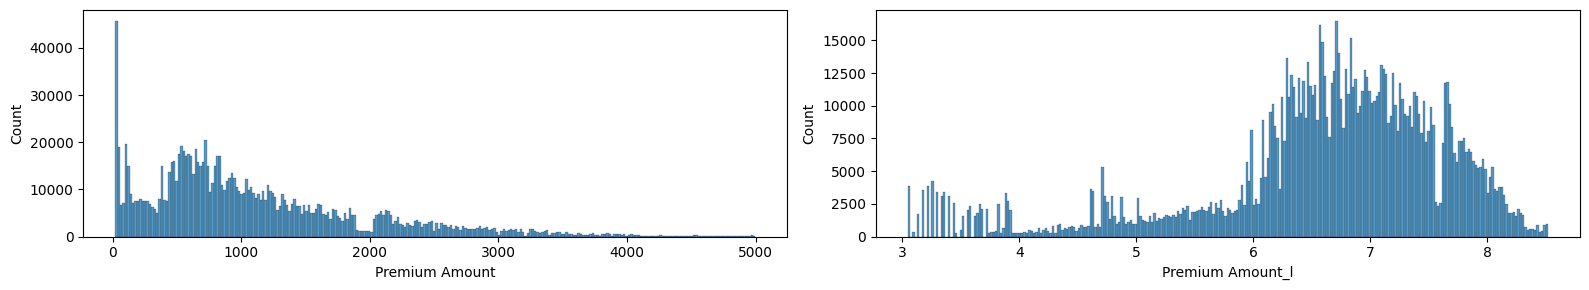

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
sns.histplot(df_train['Premium Amount'], ax=axes[0])
sns.histplot(df_train['Premium Amount_l'], ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
df_train[target].agg(['min', 'max', 'median', 'mean']), df_train[target].mode()[0]

(min       3.044523
 max       8.517193
 median    6.771935
 mean      6.593888
 Name: Premium Amount_l, dtype: float32,
 3.2580965)

In [14]:
df_train['Premium Amount'].value_counts().iloc[:10]

Premium Amount
25.0     4268
24.0     3901
20.0     3849
23.0     3524
28.0     3418
26.0     3375
48.0     3307
29.0     3139
100.0    3125
27.0     3074
Name: count, dtype: int64

# Categorical Variables

In [15]:
from scipy.stats import kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

In [16]:
pd.concat([
    df_train[i].value_counts().to_frame().pipe(lambda x: x.set_index(pd.MultiIndex.from_product([[i], x.index.tolist()], names=['Var', 'Cat'])))
    for i in X_nom
], axis = 0)

count
Var            Cat                  
Marital Status Single         395391
               Married        394316
               Divorced       391764
Occupation     Employed       282750
               Self-Employed  282645
               Unemployed     276530
Property Type  House          400349
               Apartment      399978
               Condo          399673

In [17]:
df_kruskal_tgt = sc.cache_result(
    'kruskal_tgt',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
        )
        for i in X_bool + X_ord + X_nom
    ], axis=1), rerun = False
)
df_kruskal_tgt.sort_values('pvalue', axis=1, ascending=True)

Year         Month  Occupation  Customer Feedback  Location  \
stat     7.440078e+02  7.051816e+01    6.276566           4.409469  3.429708   
pvalue  1.495212e-158  9.736743e-11    0.043357           0.110280  0.179990   

        Education Level  Policy Type  Property Type  Exercise Frequency  \
stat           3.804265     1.907457       1.738442            2.756426   
pvalue         0.283390     0.385302       0.419278            0.430723   

        Marital Status  Smoking Status   Weekday        Day    Gender  
stat          1.167640        0.169736  3.844106  22.607314  0.017928  
pvalue        0.557764        0.680346  0.697763   0.831053  0.893486

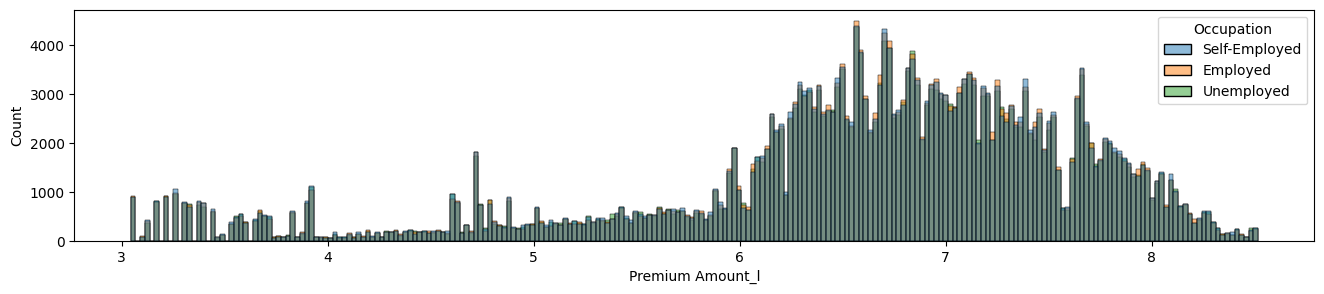

In [18]:
plt.figure(figsize=(16, 3))
sns.histplot(df_train, x=target ,hue='Occupation')
plt.show()

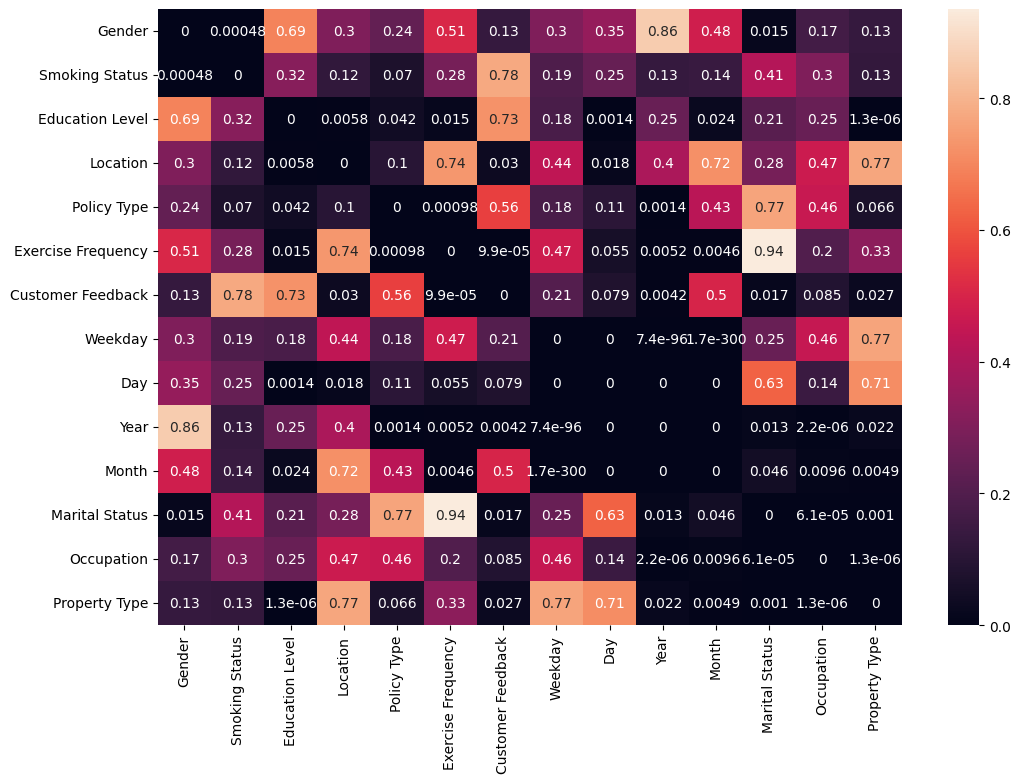

In [19]:
plt.figure(figsize=(12, 8))
df_chi2 = sc.cache_result(
    'chi2_stat',
    lambda : pd.DataFrame(
        squareform(pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns = v))[1])),
        index = X_cat, columns=X_cat
    ), rerun = 0
)
sns.heatmap(df_chi2, annot=True)
plt.show()

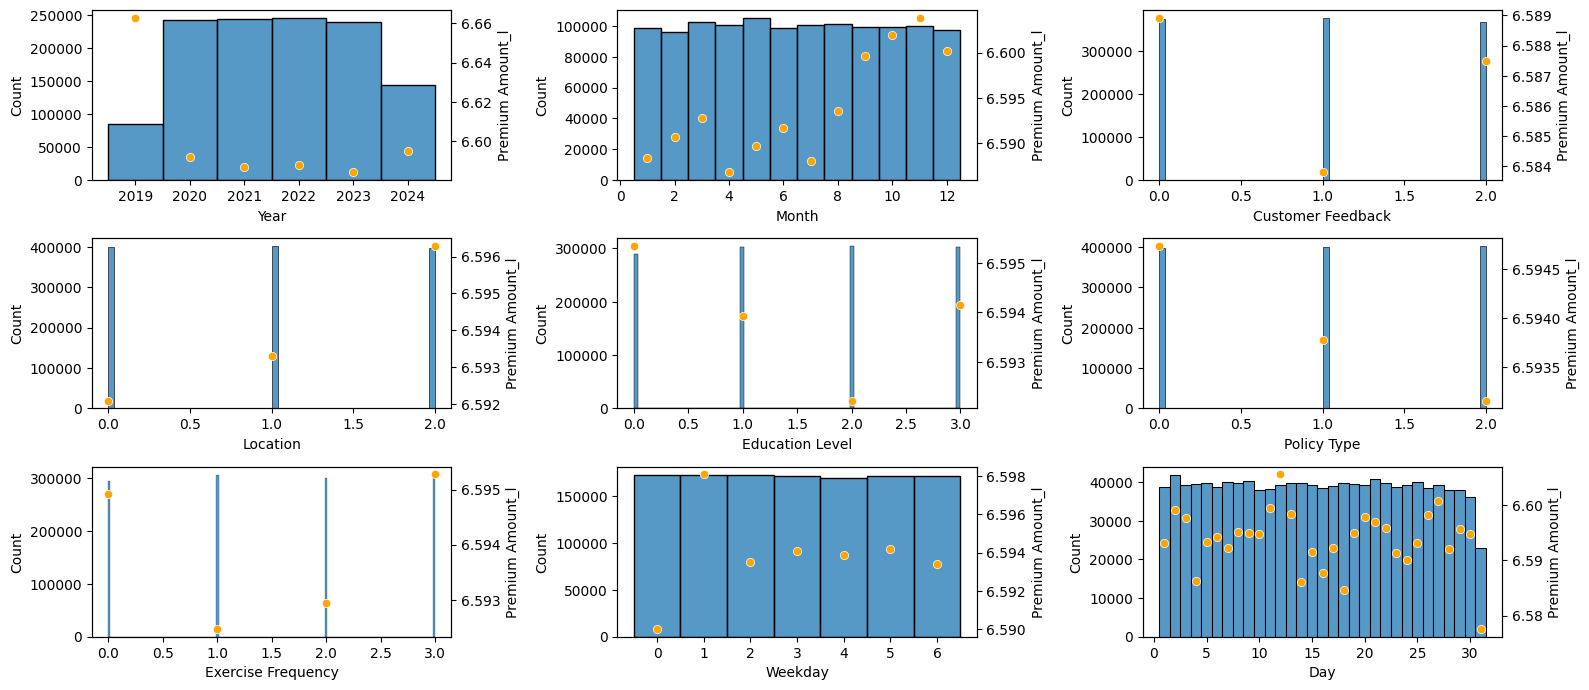

In [20]:
X = [i for i in df_kruskal_tgt.T['pvalue'].sort_values(ascending=True).index if i in X_ord]
sc.cache_fig('hist_and_scatter_ord',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw = 1
)

### Year와 Month의 관계


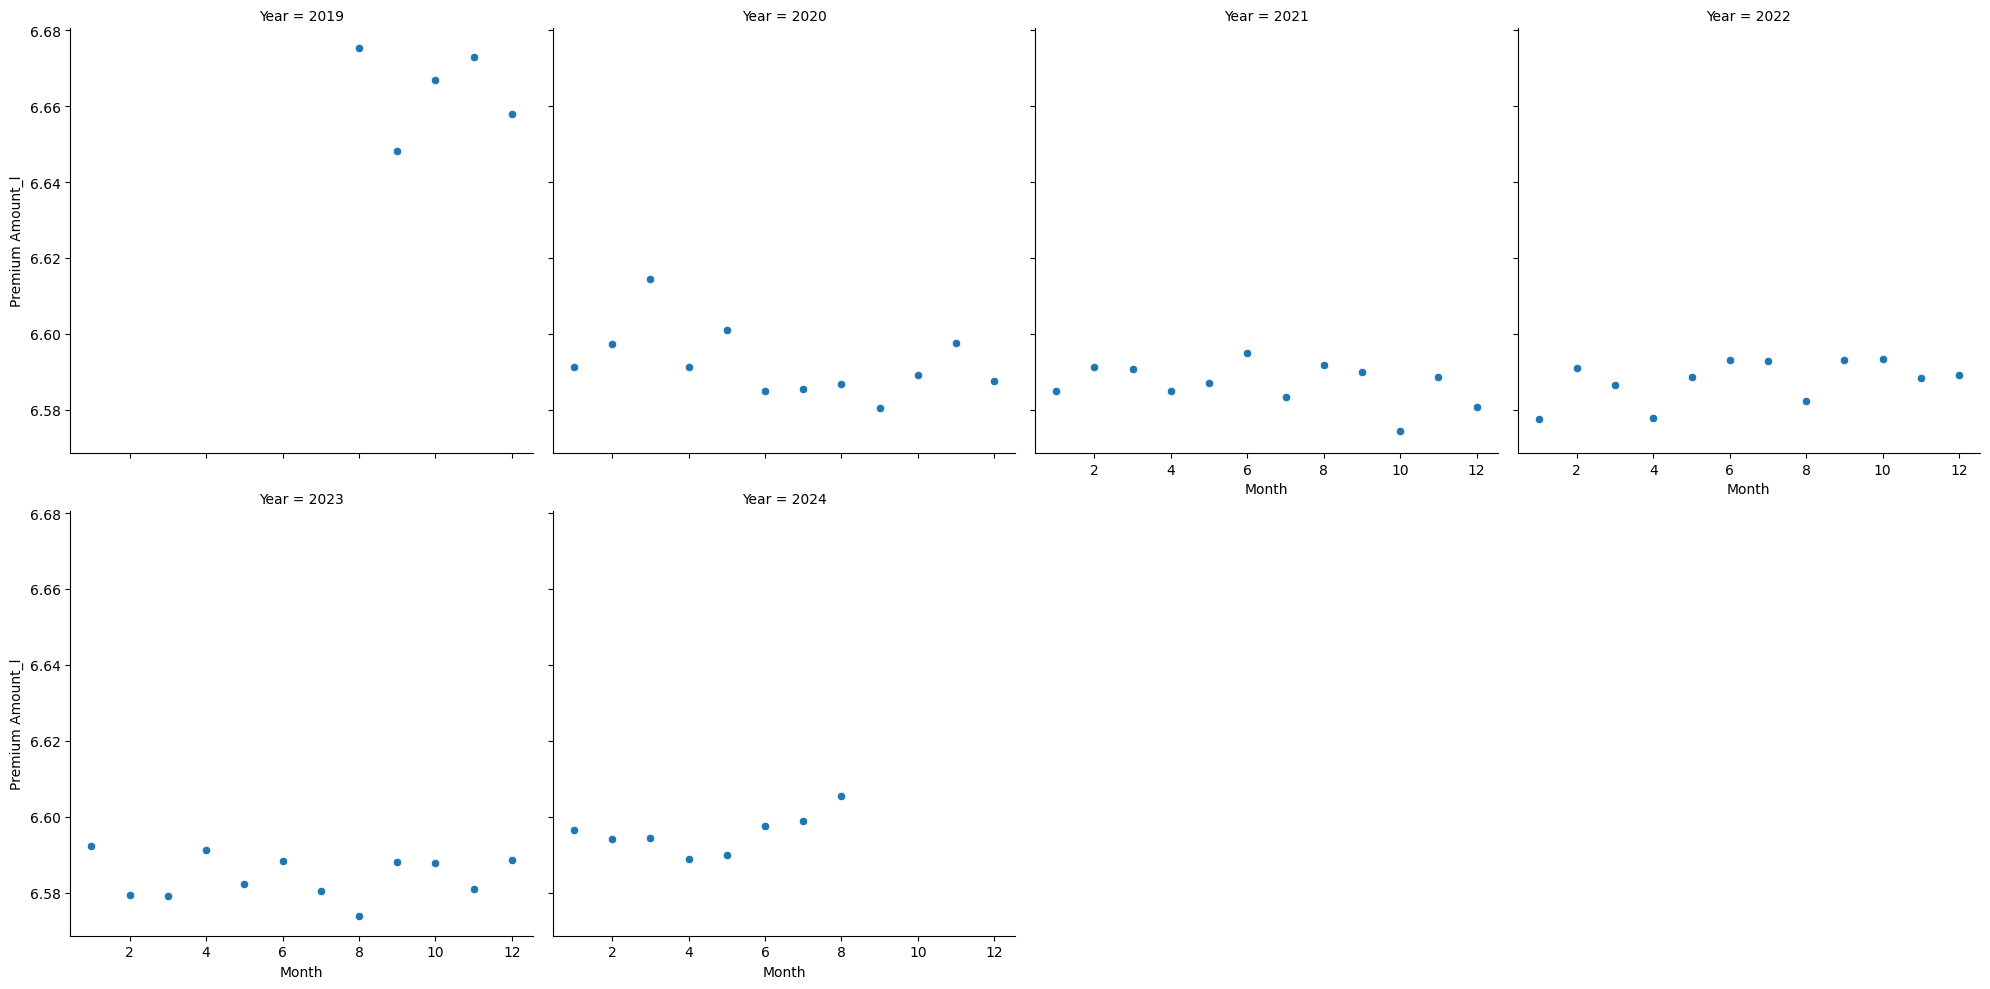

In [21]:
df_train.groupby(['Year', 'Month'], observed=True, as_index = False)[target].mean().pipe(
    lambda x: sns.relplot(x, x = 'Month', y = target, col = 'Year', kind='scatter', col_wrap = 4)
)
plt.show()

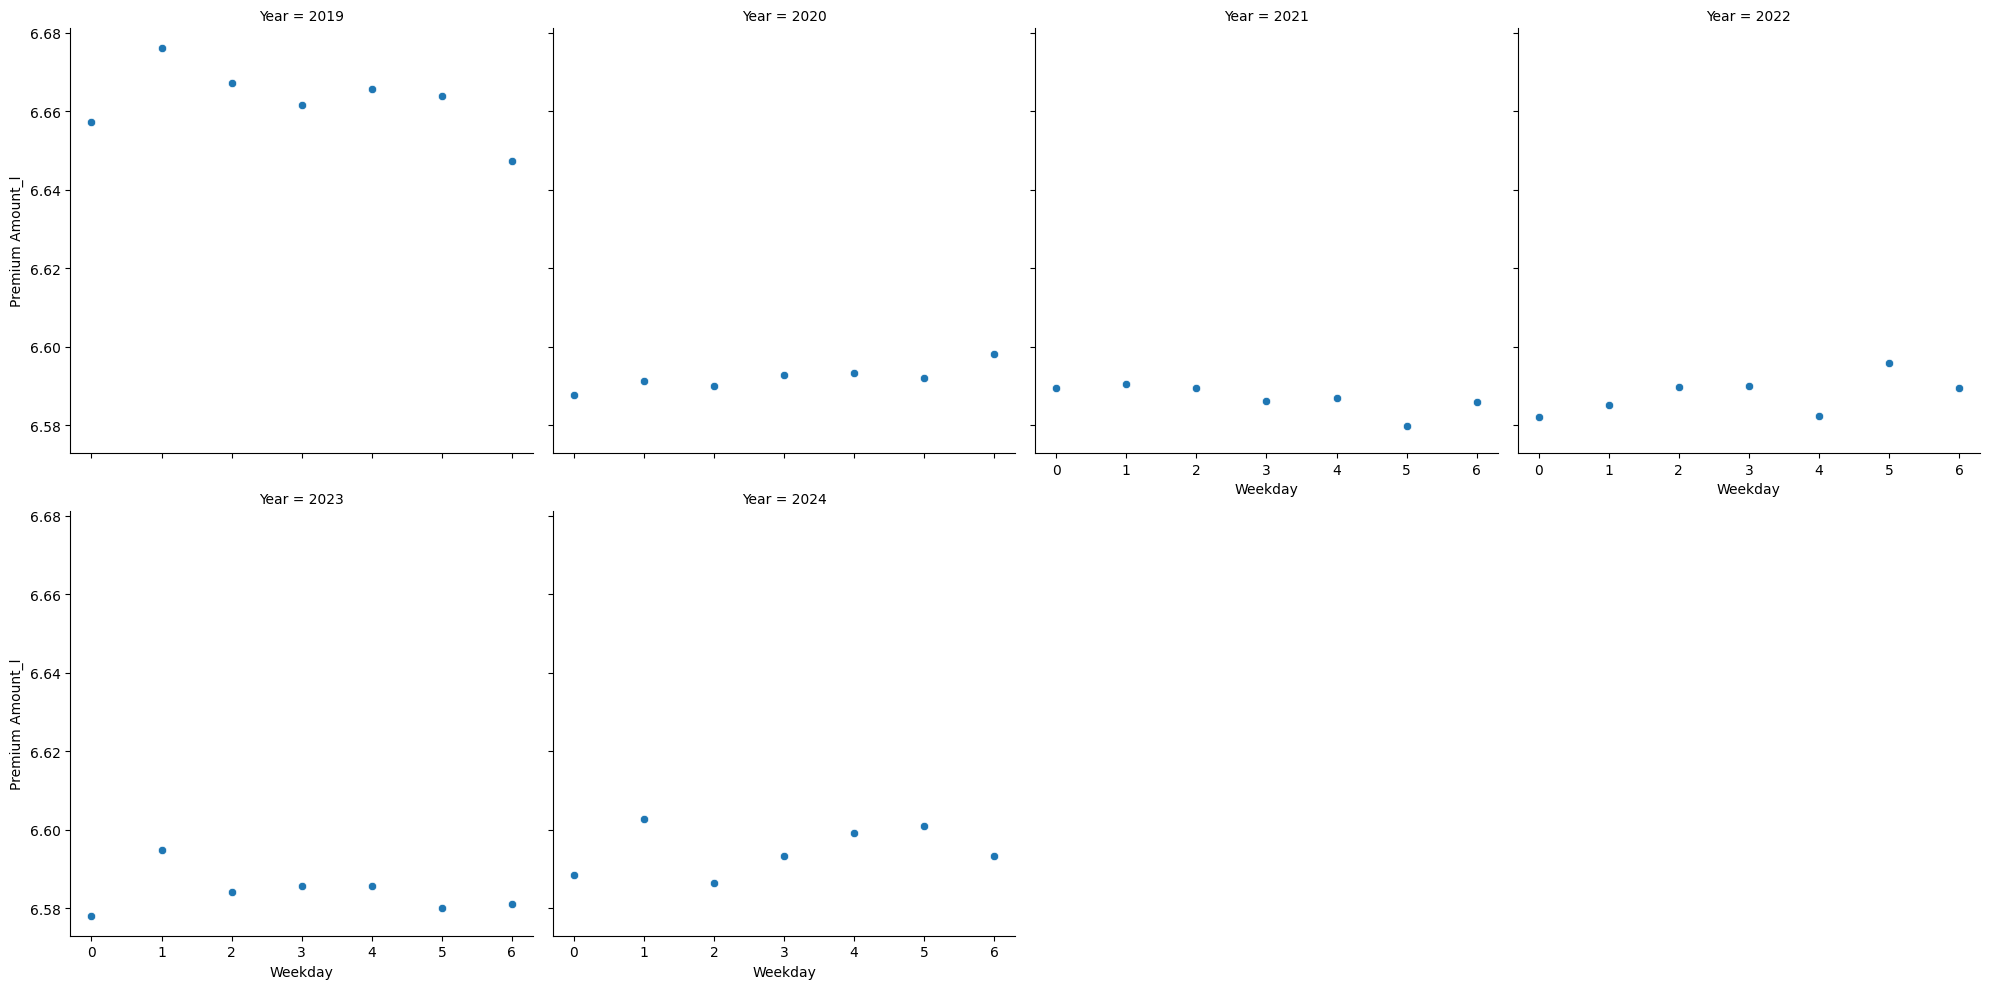

In [22]:
df_train.groupby(['Year', 'Weekday'], observed=True, as_index = False)[target].mean().pipe(
    lambda x: sns.relplot(x, x = 'Weekday', y = target, col = 'Year', kind='scatter', col_wrap = 4)
)
plt.show()

# Numeric Variables

In [23]:
from scipy.stats import kruskal, spearmanr

# Policy Start Date에서 Policy가 적용된 기간을 Policy의 최대값에서 도출합니다.
if 'Policy Days' not in df_train.columns:
    df_train['Policy Days'] = (df_train['Policy Start Date'].dt.date.max() - df_train['Policy Start Date'].dt.date).apply(lambda x: x.days)
    df_test['Policy Days'] = (df_train['Policy Start Date'].dt.date.max() - df_test['Policy Start Date'].dt.date).apply(lambda x: x.days)
    df_org['Policy Days'] = (df_train['Policy Start Date'].dt.date.max() - df_org['Policy Start Date'].dt.date).apply(lambda x: x.days)
    X_num.append('Policy Days') 

## Spearman with target

In [24]:
df_spearman_target = sc.cache_result('spearman_target',
    lambda : pd.concat([
        pd.Series(
            df_train[[i, target]].dropna().pipe(lambda x: spearmanr(x[i], x[target])),
            index = ['stat', 'pvalue'], name = i
        )
        for i in X_num
    ], axis=1)
).sort_values('pvalue', ascending=True, axis=1)
df_spearman_target

Annual Income  Credit Score  Previous Claims  Health Score  \
stat        -0.061437     -0.043928         0.044549  1.601483e-02   
pvalue       0.000000      0.000000         0.000000  9.044248e-65   

         Policy Days       Age  Number of Dependents  Vehicle Age  \
stat    1.018274e-02 -0.002329             -0.001610     0.000870   
pvalue  6.775903e-29  0.011369              0.092669     0.340707   

        Insurance Duration  
stat             -0.000071  
pvalue            0.937799

## Spearman between variables

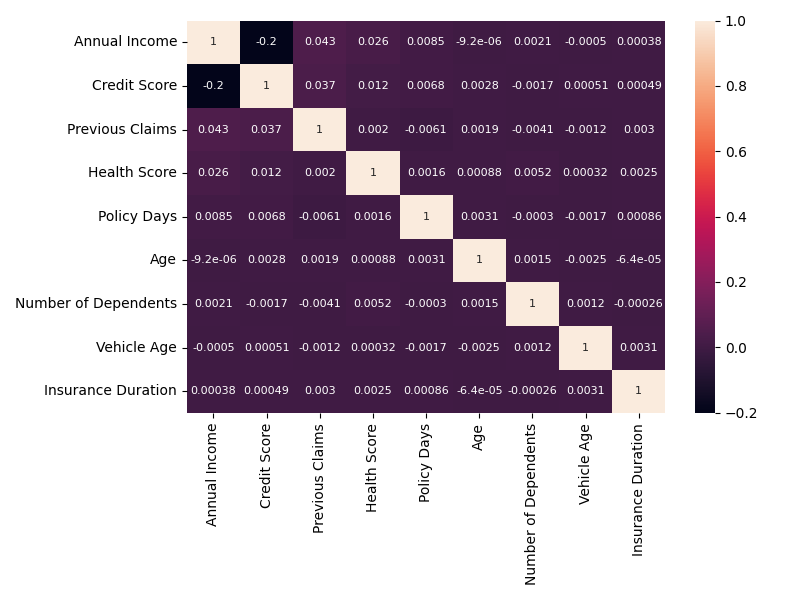

In [95]:
sc.cache_fig('spearman_between variables',
    lambda x: sns.heatmap(
        df_train[
            df_spearman_target.T['pvalue'].sort_values(ascending=True).index
        ].corr(), annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 6)
)

## Kruskal with Categorical Variables

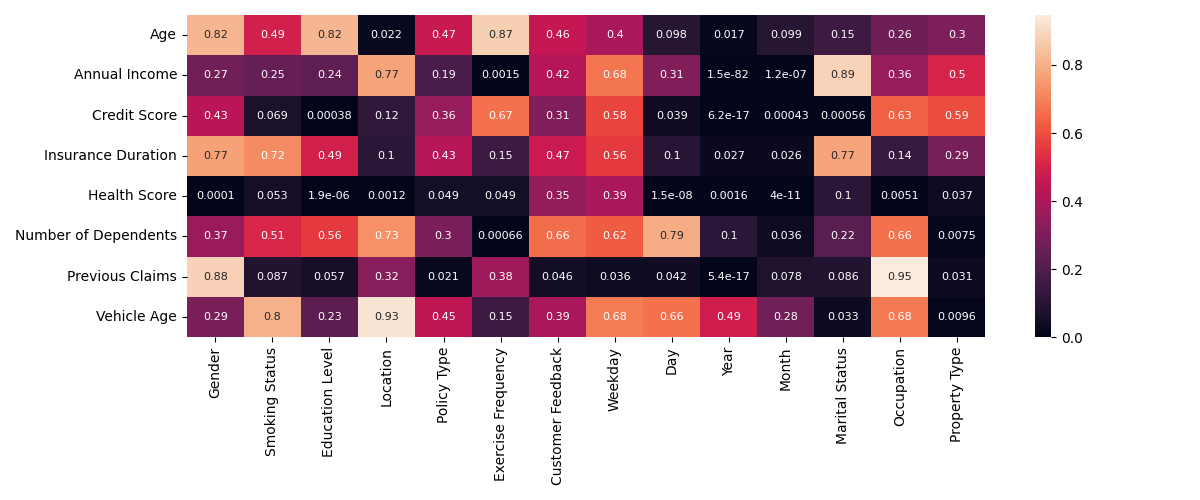

In [96]:
df_kruskal_cat = sc.cache_result('kruskal_cat', 
    lambda : pd.concat([
        df_train.groupby(df_train[i], observed=True)[X_num].agg(lambda x: x.dropna().tolist()).apply(
            lambda x: kruskal(*x).pvalue, axis=0
        ).rename(i)
        for i in X_cat
    ], axis = 1), rerun = False
)

sc.cache_fig('kruskal_cat',
    lambda x: sns.heatmap(
        df_kruskal_cat, annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (12, 5), redraw = False
)

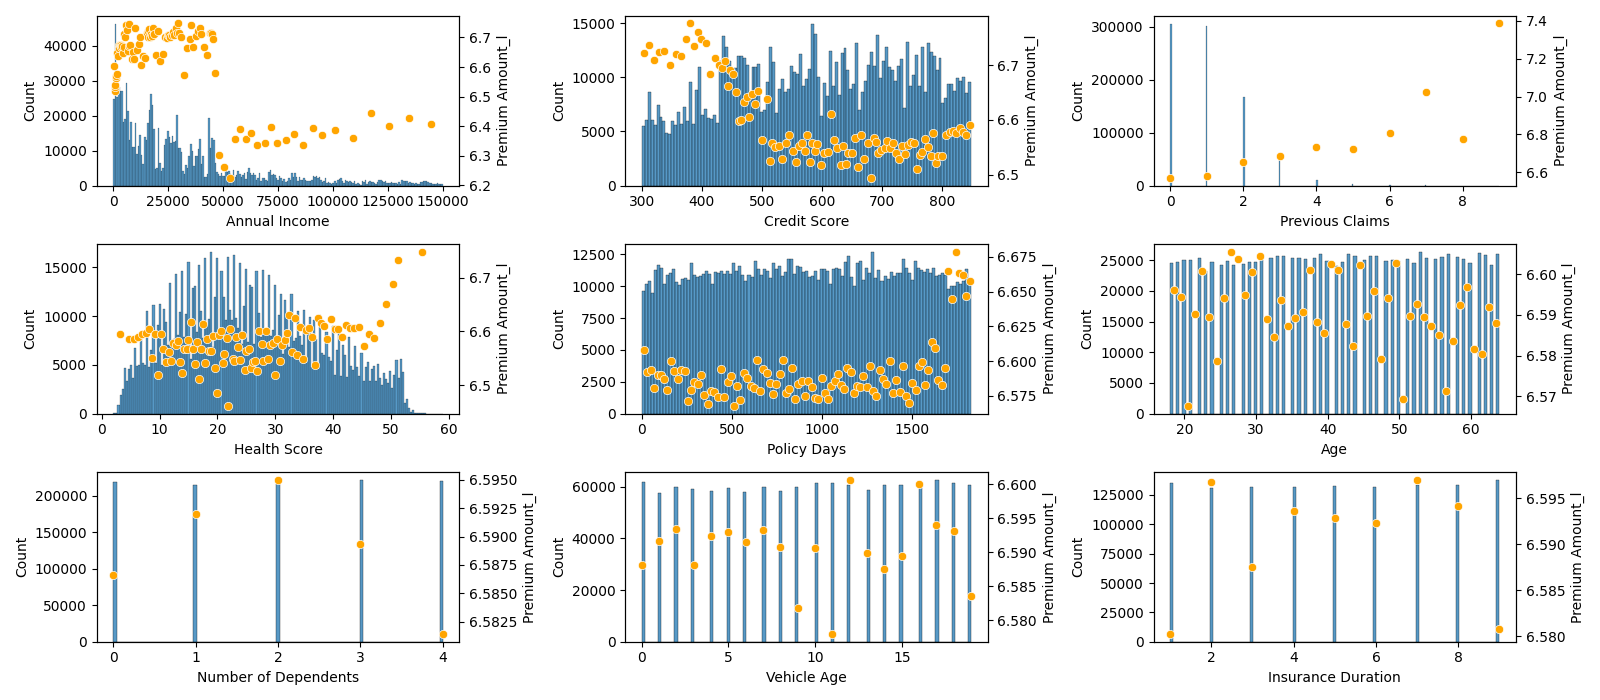

In [27]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

In [28]:
pd.concat([
    pd.Series(
        kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
    )
    for i in ['Age', 'Vehicle Age', 'Insurance Duration', 'Number of Dependents']
], axis=1)

Age  Vehicle Age  Insurance Duration  Number of Dependents
stat    89.648062    32.696028           34.352082             24.190392
pvalue   0.000124     0.026054            0.000035              0.000073

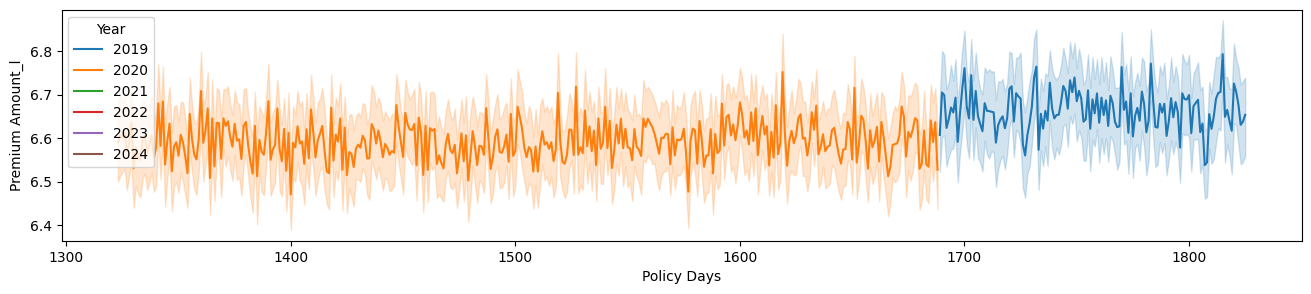

In [29]:
plt.figure(figsize = (16, 3))
sns.lineplot(df_train.query('Year == 2019 or Year == 2020'), x = 'Policy Days', y = target, hue='Year')
plt.show()

In [30]:
# 2020-1-1을 기점으로 target의 변화가 생깁니다.
df_train['Year_2019'] = df_train['Year'] == 2019

In [31]:
df_train.groupby(['Year_2019'])[target].std()

Year_2019
False    1.093716
True     1.121104
Name: Premium Amount_l, dtype: float32

In [32]:
pd.concat([
    df_train['Previous Claims'].fillna(-1).value_counts().rename('cnt'),
    df_train.groupby(df_train['Previous Claims'].fillna(-1))[target].agg(['mean', 'std'])
], axis=1).T

Previous Claims           -1.0            0.0            1.0            2.0  \
cnt              364029.000000  305433.000000  300811.000000  167661.000000   
mean                  6.570288       6.573611       6.584603       6.659235   
std                   1.089575       1.093892       1.091891       1.112314   

Previous Claims           3.0           4.0          5.0         6.0  \
cnt              49011.000000  10668.000000  2018.000000  302.000000   
mean                 6.691059      6.734332     6.727364    6.809397   
std                  1.106070      1.090079     1.098397    1.093210   

Previous Claims        7.0       8.0      9.0  
cnt              58.000000  8.000000  1.00000  
mean              7.024037  6.778293  7.38709  
std               0.848970  1.193785      NaN

In [33]:
df_train['Previous Claims_C'] = df_train['Previous Claims'].fillna(-1).clip(-1, 7)

In [34]:
df_train.groupby('Year_2019')[['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims', target]].mean()

Annual Income  Credit Score  Health Score  Previous Claims  \
Year_2019                                                               
False       32480.503906    592.682922     25.598755         1.002977   
True        36263.808594    596.130676     25.812834         0.998899   

           Premium Amount_l  
Year_2019                    
False              6.588686  
True               6.662757

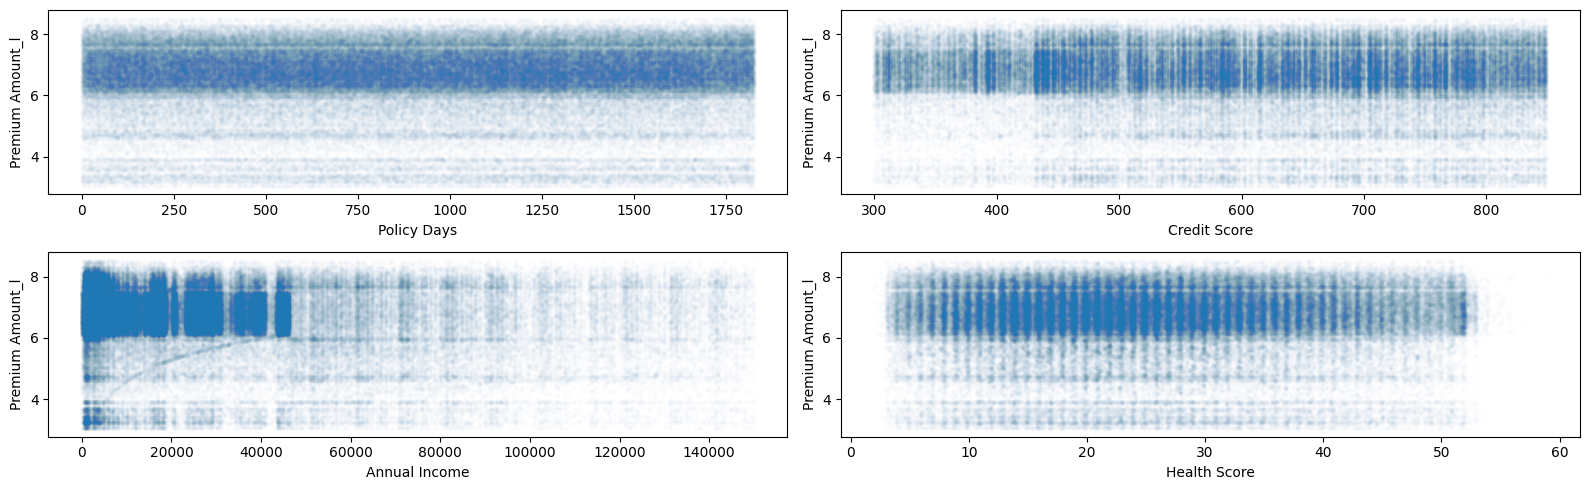

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 5))
for i, ax in zip(['Policy Days', 'Credit Score', 'Annual Income', 'Health Score'], axes.flatten()):
    sns.scatterplot(
        df_train.sample(frac = 0.2), x = i, y = target, alpha = 0.01, s = 10, ax = ax
    )
plt.tight_layout()
plt.show()

In [36]:
display(df_train.groupby(df_train['Annual Income'] >= 46500)[target].std())
df_train['Annual Income_46K'] = df_train['Annual Income'] >= 46500

Annual Income
False    1.017953
True     1.318848
Name: Premium Amount_l, dtype: float32

In [37]:
df_train['Annual Income_b'] = pd.cut(df_train['Annual Income'], bins=[0, 2400, 46500, np.inf], labels=[0, 1, 2])
display(df_train.groupby('Annual Income_b', observed=True)[target].std())

Annual Income_b
0    1.209969
1    0.964980
2    1.318850
Name: Premium Amount_l, dtype: float32

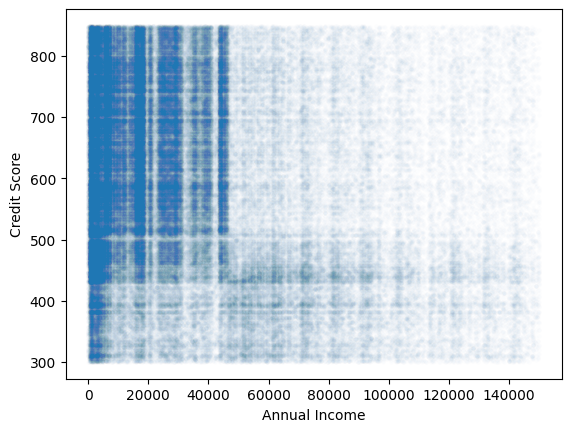

In [38]:
sns.scatterplot(df_train.sample(frac = 0.3), x = 'Annual Income', y = 'Credit Score', s = 10, alpha = 0.01)
plt.show()

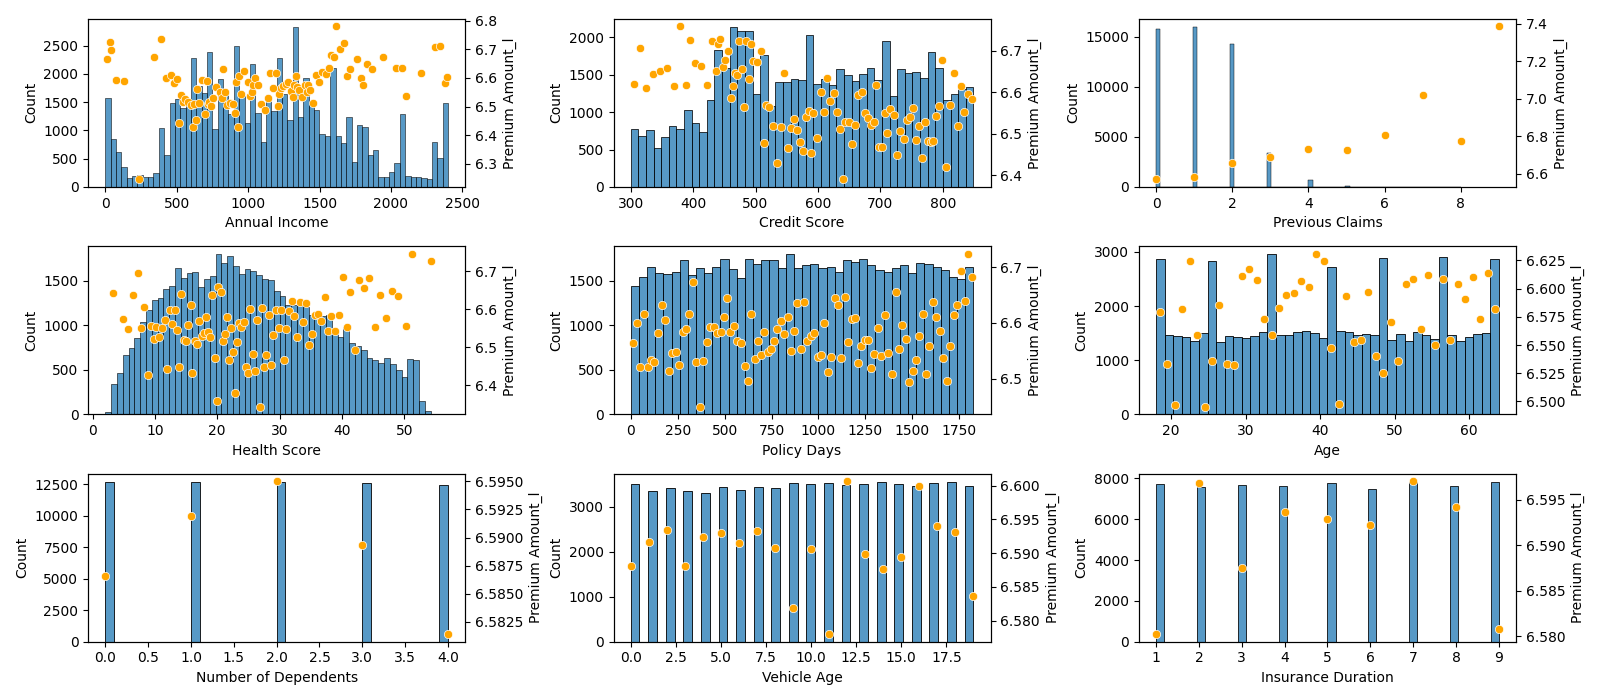

In [39]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter2',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 0'), i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

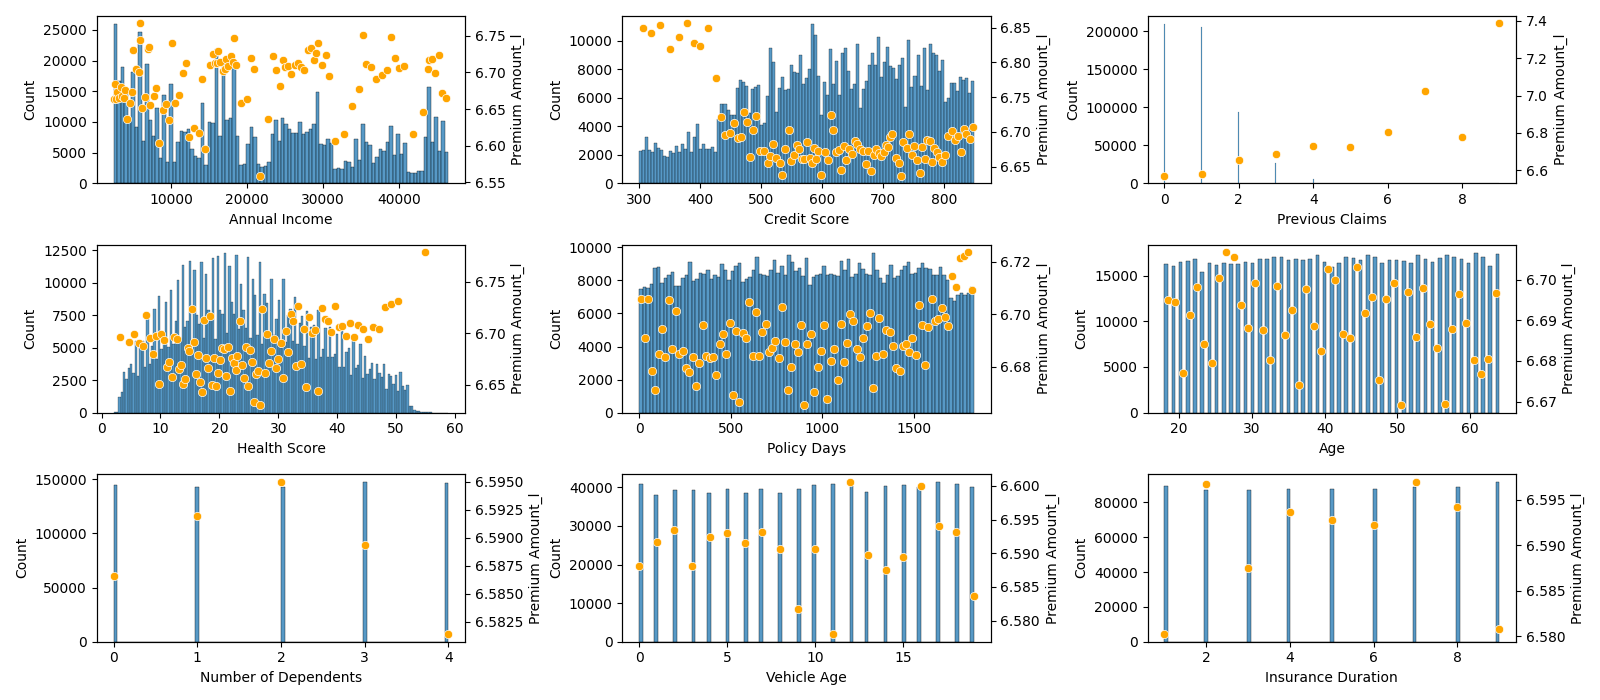

In [40]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter3',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 1'), i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

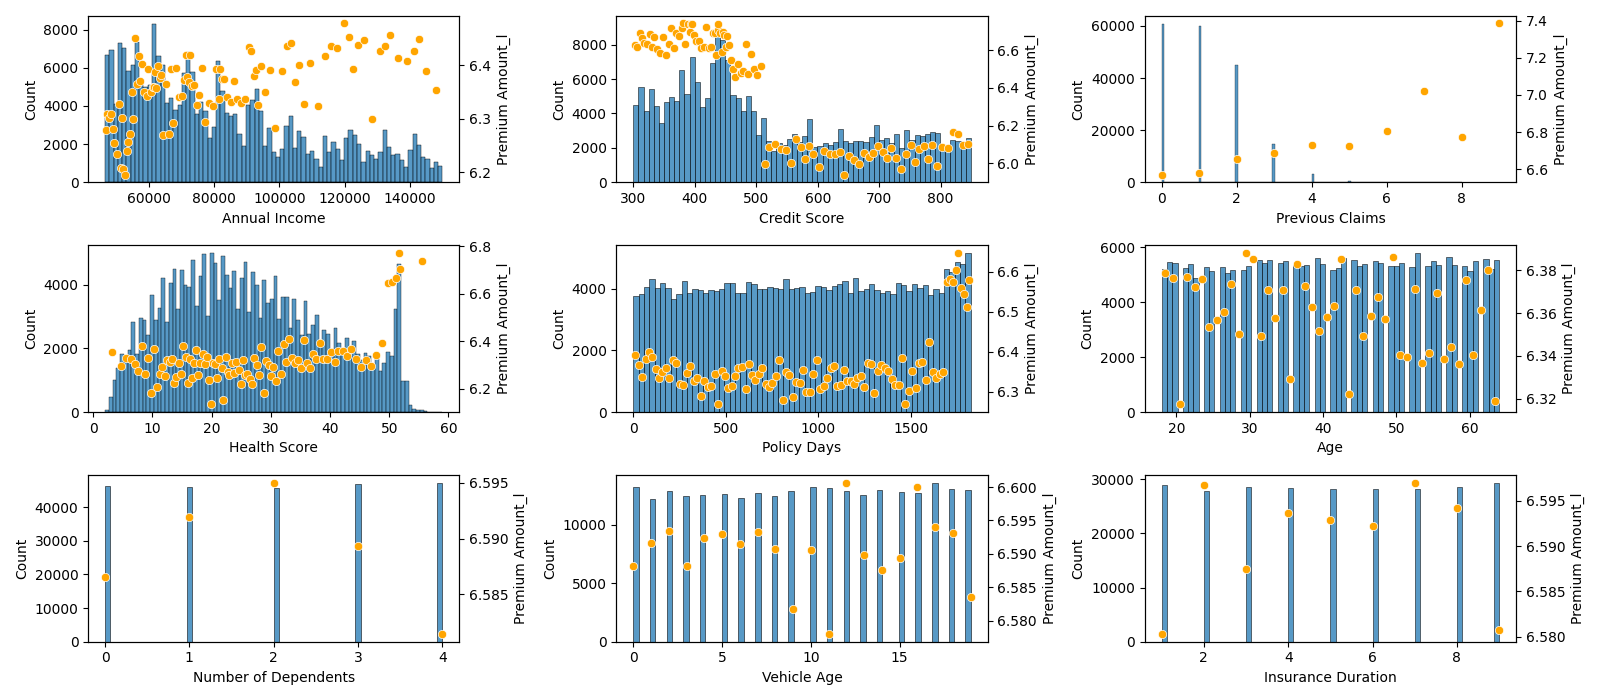

In [41]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter4',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 2'), i, ax) for i, ax in zip(x, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

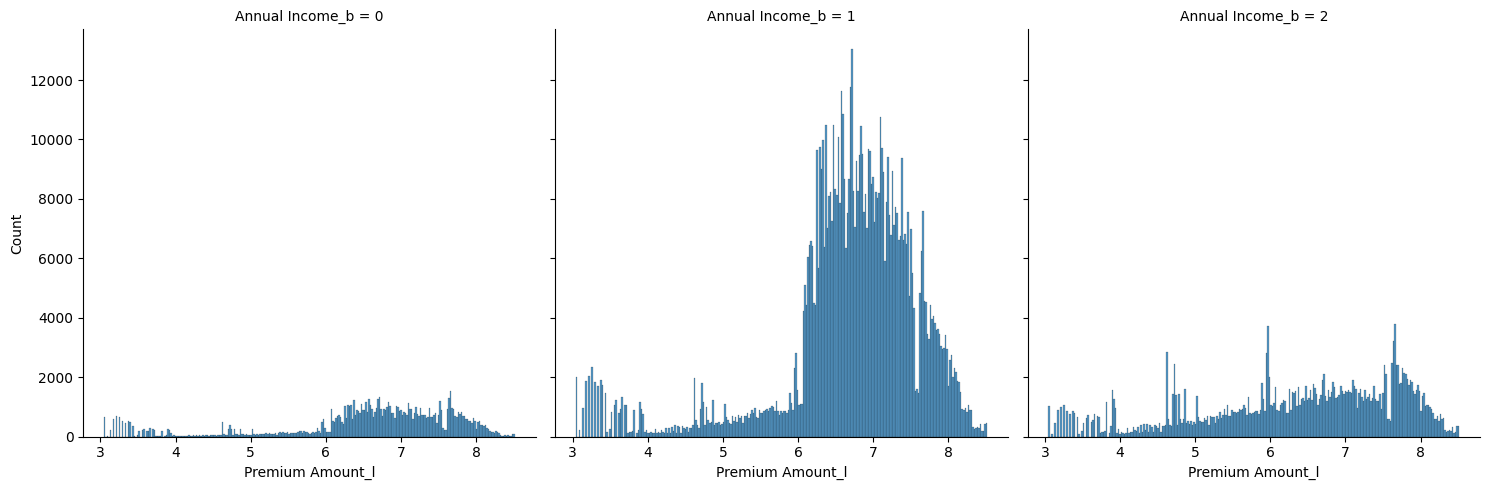

In [42]:
sns.displot(df_train, x = target , col = 'Annual Income_b')

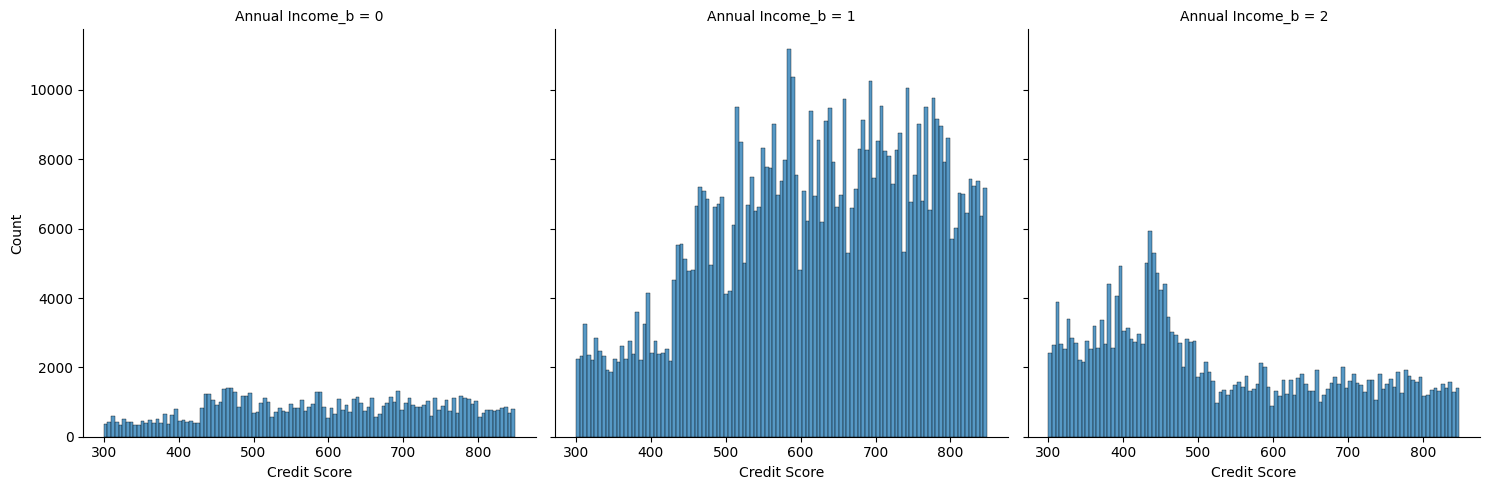

In [43]:
sns.displot(df_train, x = 'Credit Score' , col = 'Annual Income_b')

In [44]:
from scipy.stats import pearsonr
df_train[['Annual Income', target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby(x['Annual Income']).transform('size'),
        x[target]
    ), (x['Annual Income']).nunique())
)

(PearsonRResult(statistic=0.07052305558307564, pvalue=0.0), 88593)

In [45]:
from scipy.stats import pearsonr
df_train[['Credit Score', target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby(x['Credit Score'] // 50).transform('size'),
        x[target]
    ), (x['Credit Score'] // 50).nunique())
)

(PearsonRResult(statistic=-0.049259892232267725, pvalue=0.0), 11)

In [46]:
df_train[['Health Score', target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby((x['Health Score'] * 7) // 1).transform('size'),
        x[target]
    ), ((x['Health Score'] * 7) // 1).nunique())
)

(PearsonRResult(statistic=-0.03094659784376715, pvalue=1.3367889147760433e-236),
 390)

In [47]:
col = 'Policy Days'
df_train[[col, target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby(x[col]).transform('size'),
        x[target]
    ), (x[col]).nunique())
)

(PearsonRResult(statistic=-0.007529194030606717, pvalue=1.6116560007532267e-16),
 1826)

In [48]:
s_vcnt_A = (pd.concat([df_train['Annual Income'], df_test['Annual Income']]) // 1).value_counts()
s_vcnt_C = (pd.concat([df_train['Credit Score'], df_test['Credit Score']]) // 50).value_counts()
s_vcnt_H = ((pd.concat([df_train['Health Score'], df_test['Health Score']]) * 7) // 1).value_counts()
df_train['Annual Income_Freq'] = (df_train['Annual Income'] // 1).map(s_vcnt_A)
df_train['Credit Score_Freq'] = (df_train['Credit Score'] // 50).map(s_vcnt_C)
df_train['Health Score_Freq'] = ((df_train['Health Score'] * 7) // 1).map(s_vcnt_H)

df_test['Annual Income_Freq'] = (df_test['Annual Income'] // 1).map(s_vcnt_A)
df_test['Credit Score_Freq'] = (df_test['Credit Score'] // 50).map(s_vcnt_C)
df_test['Health Score_Freq'] = ((df_test['Health Score'] * 7) // 1).map(s_vcnt_H)

df_train['Annual Income_Freqz'] = df_train['Annual Income_Freq'].fillna(0)
df_train['Credit Score_Freqz'] = df_train['Credit Score_Freq'].fillna(0)
df_train['Health Score_Freqz'] = df_train['Health Score_Freq'].fillna(0)

In [49]:
df_train[['Annual Income_Freq', 'Credit Score_Freq', 'Health Score_Freq', target]].corr()

Annual Income_Freq  Credit Score_Freq  Health Score_Freq  \
Annual Income_Freq            1.000000           0.144556           0.026076   
Credit Score_Freq             0.144556           1.000000           0.011064   
Health Score_Freq             0.026076           0.011064           1.000000   
Premium Amount_l              0.070532          -0.049280          -0.030919   

                    Premium Amount_l  
Annual Income_Freq          0.070532  
Credit Score_Freq          -0.049280  
Health Score_Freq          -0.030919  
Premium Amount_l            1.000000

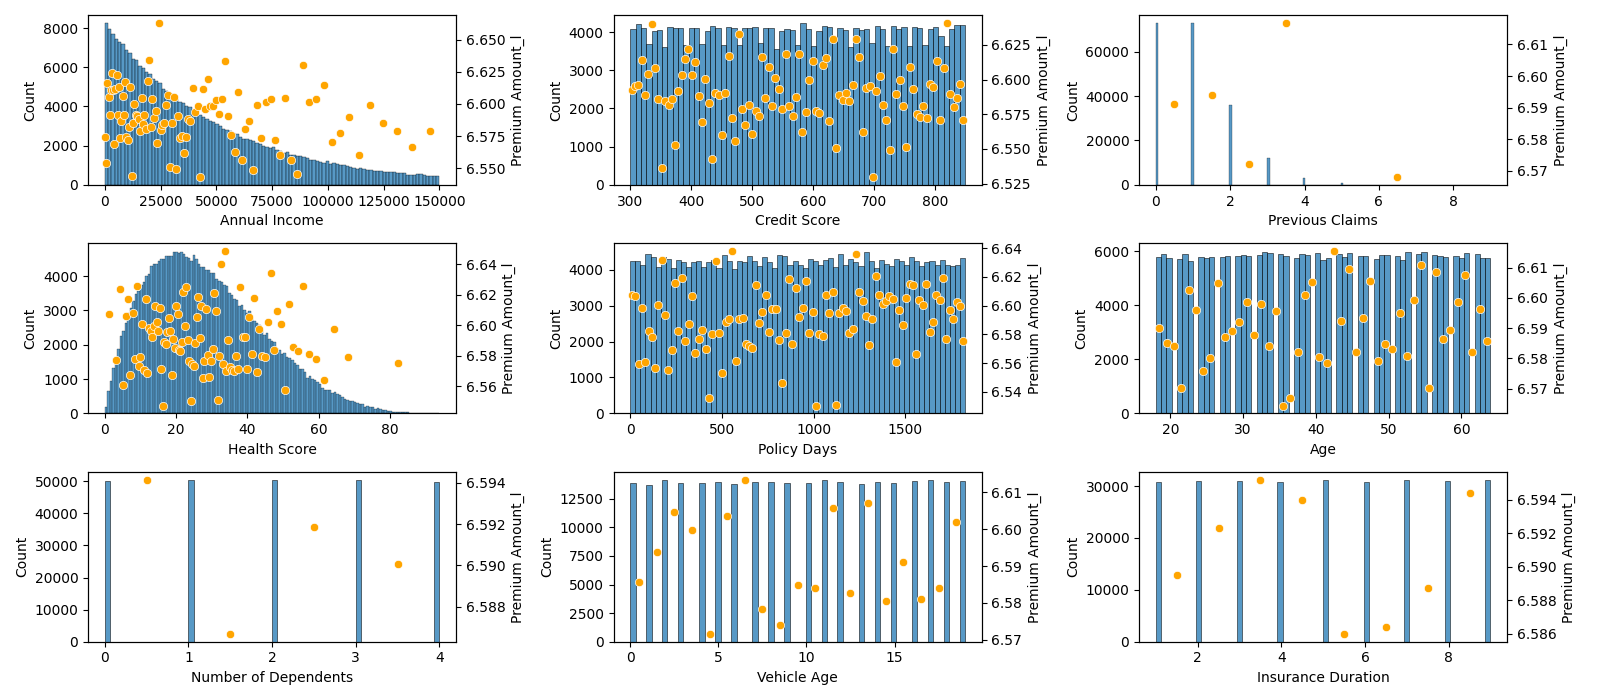

In [50]:
X = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter_org',
    lambda axes: [hist_and_scatter(df_org, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw=0
)

# Missing Variables

In [51]:
pd.concat([
    df_train[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(train)').sort_values(ascending=False).to_frame().T,
    df_test[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(test)').sort_values(ascending=False).to_frame().T,
    df_org[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(org)').sort_values(ascending=False).to_frame().T
], axis=0).fillna(0)

Previous Claims  Occupation  Credit Score  \
na_rate(train)         0.303358    0.298396      0.114902   
na_rate(test)          0.303503    0.298906      0.114314   
na_rate(org)           0.291501    0.291501      0.100000   

                Number of Dependents  Customer Feedback  Health Score  \
na_rate(train)              0.091393           0.064853      0.061730   
na_rate(test)               0.091412           0.065345      0.061811   
na_rate(org)                0.100000           0.065800      0.038001   

                Annual Income       Age  Marital Status  Vehicle Age  \
na_rate(train)       0.037457  0.015588        0.015441     0.000005   
na_rate(test)        0.037325  0.015611        0.015420     0.000004   
na_rate(org)         0.050043  0.016801        0.017998     0.000000   

                Insurance Duration  
na_rate(train)        8.333333e-07  
na_rate(test)         2.500000e-06  
na_rate(org)          0.000000e+00

In [52]:
if 'Previous Claims_isna' not in df_train.columns:
    X_isna = ['Previous Claims', 'Occupation', 'Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age', 'Marital Status']
    df_train = df_train.join(df_train[X_isna].isna().rename(columns = lambda x: x + '_isna'))
    df_org = df_org.join(df_org[X_isna].rename(columns = lambda x: x + '_isna'))
    X_isna = [i + '_isna' for i in X_isna]

## Missing Value Processing

In [53]:
# 수치형 변수의 결측치를 0으로 채웁니다.
if 'Credit Score_fz' not in df_train.columns:
    X_fn = ['Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age']
    df_fz = df_train[X_fn].fillna(0).astype('int').rename(columns = lambda x: x + '_fz')
    df_train = df_train.join(df_fz)
    df_fz = df_org[X_fn].fillna(0).astype('int').rename(columns = lambda x: x + '_fz')
    df_org = df_org.join(df_fz)
    df_fz = df_test[X_fn].fillna(0).astype('int').rename(columns = lambda x: x + '_fz')
    df_test = df_test.join(df_fz)

In [54]:
# 명목형 변수의 결측치를 Unknown으로 채웁니다.
if 'Occupation_funk' not in df_train.columns:
    df_train['Occupation_funk'] = df_train['Occupation'].cat.add_categories('Unknown').fillna('Unknown')
    df_train['Marital Status_funk'] = df_train['Marital Status'].cat.add_categories('Unknown').fillna('Unknown')
    df_train['Customer Feedback_fm1'] = df_train['Customer Feedback'].fillna(-1).astype('int8')
    df_train['Previous Claims_fm1'] = df_train['Previous Claims'].fillna(-1).astype('int8')
    df_train['Vehicle Age_fm1'] = df_train['Vehicle Age'].fillna(-1).astype('int8')
    
    df_org['Occupation_funk'] = df_org['Occupation'].cat.add_categories('Unknown').fillna('Unknown')
    df_org['Marital Status_funk'] = df_org['Marital Status'].cat.add_categories('Unknown').fillna('Unknown')
    df_org['Customer Feedback_fm1'] = df_org['Customer Feedback'].fillna(-1).astype('int8')
    df_org['Previous Claims_fm1'] = df_org['Previous Claims'].fillna(-1).astype('int8')

    df_test['Occupation_funk'] = df_test['Occupation'].cat.add_categories('Unknown').fillna('Unknown')
    df_test['Marital Status_funk'] = df_test['Marital Status'].cat.add_categories('Unknown').fillna('Unknown')
    df_test['Customer Feedback_fm1'] = df_test['Customer Feedback'].fillna(-1).astype('int8')
    df_test['Previous Claims_fm1'] = df_test['Previous Claims'].fillna(-1).astype('int8')
    df_test['Vehicle Age_fm1'] = df_test['Vehicle Age'].fillna(-1).astype('int8')

# Train/Test/Org Difference

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_roc_auc_diff(df_0, df_1, X_input):
    df_diff = pd.concat([
        df_0[X_input].assign(is_1 = False),
        df_1[X_input].assign(is_1 = True)
    ], axis = 0)
    df_train_diff, df_test_diff = train_test_split(df_diff, train_size = 0.8, stratify = df_diff['is_1'])
    clf_diff = lgb.LGBMClassifier(random_state=123, verbose = 0)
    clf_diff.fit(df_diff[X_input], df_diff['is_1'], categorical_feature = X_cat)
    return (
        roc_auc_score(df_test_diff['is_1'], clf_diff.predict_proba(df_test_diff[X_input])[:, 1]),
        pd.Series(clf_diff.feature_importances_, index=X_input)
    )
(roc1, s_imp1), (roc2, s_imp2) = sc.cache_result('diff_result',
    lambda : (
        get_roc_auc_diff(df_train, df_test, X_cat + X_num),
        get_roc_auc_diff(df_train, df_org, X_cat + X_num + ['Premium Amount'] + X_isna)
    ), rerun=0
)
roc1, roc2

(0.5357095850911459, 0.8108993313550408)

In [56]:
s_imp2.sort_values(ascending=False).iloc[:15].to_frame().T

Annual Income  Health Score  Premium Amount  Credit Score  Previous Claims  \
0            883           757             650           399              150   

   Marital Status_isna  Policy Days  Number of Dependents  Education Level  \
0                   72           67                    11                4   

   Age  Occupation_isna  Exercise Frequency  Vehicle Age  Age_isna  \
0    3                2                   1            1         0   

   Annual Income_isna  
0                   0

Train은 Test와 구분이 어려운 것으로 보아 차이가 크지 않음을 알 수 있고,

Org와는 차이가 보입니다. Org 데이터를 포함하여 학습시키는 것은 성능의 개선을 주지 않을 가능성이 큽니다. 

In [57]:
from sklearn.metrics import mean_squared_error
def check_improve():
    df_org[target] = np.log(df_org['Premium Amount'] + 1e-7)
    df_train_2, df_valid = train_test_split(df_train, train_size = 0.8)
    return (
        mean_squared_error(
            df_valid[target],
            lgb.LGBMRegressor(random_state = 123, verbose=0).fit(df_train_2[X_cat + X_num], df_train_2[target]).predict(df_valid[X_cat + X_num])
        ),
        mean_squared_error(
            df_valid[target],
            pd.concat([df_train_2[X_cat + X_num + [target]], df_org[X_cat + X_num + [target]]])\
            .pipe(lambda x: lgb.LGBMRegressor(random_state = 123, verbose=0).fit(x[X_cat + X_num], x[target]).predict(df_valid[X_cat + X_num]))
        )
    )
sc.cache_result('check_improve', check_improve)

(1.1154423300794376, 1.1327478698101194)

# Interaction

In [ ]:
# Number of Dependents	Vehicle Age	Insurance Duration
# Policy Type	Property Type	Exercise Frequency	Marital Status	Smoking Status	

In [213]:
kruskal(
    *df_train.groupby(
        dproc.combine_cat(df_train[['Gender', 'Number of Dependents_fz']].assign(
            G = lambda x: x['Gender'].astype('category'),
            CF_cat = lambda x: x['Number of Dependents_fz'].astype('category')
        ).drop(columns = ['Gender','Number of Dependents_fz']), '_'), observed = True
    )[target].agg(lambda x: list(x.dropna()))
)

KruskalResult(statistic=30.309543168057544, pvalue=0.00038855552993262394)

In [233]:
kruskal(
    *df_train.groupby(
        dproc.combine_cat(df_train[['Policy Type', 'Customer Feedback_fm1']].assign(
            G = lambda x: x['Policy Type'].astype('category'),
            CF_cat = lambda x: x['Customer Feedback_fm1'].astype('str').astype('category')
        ).drop(columns = ['Policy Type','Customer Feedback_fm1']), '_'), observed = True
    )[target].agg(lambda x: list(x.dropna()))
)

KruskalResult(statistic=1047.7256003739087, pvalue=1.0247982169844411e-217)

In [230]:
kruskal(
    *df_train.groupby(
        dproc.combine_cat(df_train[['Gender', 'Marital Status']].assign(
            G = lambda x: x['Gender'].astype('category'),
            CF_cat = lambda x: x['Marital Status'].astype('str').astype('category')
        ).drop(columns = ['Gender','Marital Status']), '_'), observed = True
    )[target].agg(lambda x: list(x.dropna()))
)

KruskalResult(statistic=373.5061094497086, pvalue=1.1391825279695068e-76)

In [231]:
kruskal(
    *df_train.groupby(
        dproc.combine_cat(df_train[['Policy Type', 'Marital Status']].assign(
            G = lambda x: x['Policy Type'].astype('category'),
            CF_cat = lambda x: x['Marital Status'].astype('str').astype('category')
        ).drop(columns = ['Policy Type','Marital Status']), '_'), observed = True
    )[target].agg(lambda x: list(x.dropna()))
)

KruskalResult(statistic=376.8094316512106, pvalue=5.0859197412718214e-74)

# Marital Status & Customer Feedback

In [58]:
df_train['Marital_Feedback'] = dproc.combine_cat(df_train[['Marital Status_funk', 'Customer Feedback_fm1']].assign(
    CF_cat = lambda x: x['Customer Feedback_fm1'].astype('category')
).drop(columns = ['Customer Feedback_fm1']), '_')

df_test['Marital_Feedback'] = dproc.combine_cat(df_test[['Marital Status_funk', 'Customer Feedback_fm1']].assign(
    CF_cat = lambda x: x['Customer Feedback_fm1'].astype('category')
).drop(columns = ['Customer Feedback_fm1']), '_')

In [146]:
kruskal(
    *df_train.groupby(
        dproc.combine_cat(df_train[['Marital Status_funk', 'Customer Feedback_fm1']].assign(
            CF_cat = lambda x: x['Customer Feedback_fm1'].astype('category')
        ).drop(columns = ['Customer Feedback_fm1']), '_'), observed = True
    )[target].agg(lambda x: list(x.dropna()))
)

KruskalResult(statistic=1429.045687854355, pvalue=9.324099009910076e-296)

In [60]:
sc.cache_result(
    'kruskal_MC',
    lambda : pd.concat([
        pd.Series(kruskal(
            *df_train.groupby('Marital_Feedback', observed = True)[i].agg(lambda x: list(x.dropna()))
        ), index = ['stat', 'pvalue'], name=i)
        for i in X_num
    ], axis=1)
)

Age  Annual Income  Credit Score  Insurance Duration  \
stat    18.548716   1.299060e+03  4.602663e+02           10.250920   
pvalue   0.234917  8.450317e-268  1.404620e-88            0.803667   

        Health Score  Number of Dependents  Previous Claims  Vehicle Age  \
stat       34.742899             16.092080     1.719204e+02    42.576379   
pvalue      0.002675              0.375959     1.005699e-28     0.000183   

        Policy Days  
stat      28.402403  
pvalue     0.019182

In [135]:
sc.cache_result(
    'chi2_MC',
    lambda : pd.concat([
        pd.Series(chi2_contingency(
            df_train.groupby(['Marital_Feedback', i], observed = True).size().unstack()
        )[:2], index = ['stat', 'pvalue'], name=i)
        for i in X_cat
    ], axis=1)
).dropna(axis=1).sort_values('pvalue', axis=1)

Year  Property Type  Occupation   Location     Weekday  \
stat    1.560036e+02      65.727727   61.623324  48.266993  117.932713   
pvalue  1.254669e-07       0.000177    0.000583   0.018643    0.025749   

           Gender  Exercise Frequency       Month         Day  \
stat    25.511365           60.863322  174.803724  463.037867   
pvalue   0.043483            0.057431    0.285739    0.325404   

        Education Level  Smoking Status  Policy Type  
stat          46.059221       15.282396    19.940130  
pvalue         0.428185        0.431274     0.918091

# Analyze with ML

In [61]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index=df.index),
    'score_func': lambda df, prds: mean_squared_error(df[target].sort_index(), prds.sort_index()) ** 0.5,
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': target,
}

lr_adapter = sgml.SklearnAdapter(LinearRegression)
cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)

In [62]:
def gb_shap_learning_result(train_result, df, interaction = True):
    explainer = shap.TreeExplainer(train_result['model'])
    processor = train_result['preprocessor']
    result = {
        'X': pd.DataFrame(processor.transform(df), index=df.index, columns=train_result['variables'])
    }
    result['shap_values'] = explainer.shap_values(result['X'])
    if interaction:
        result['shap_interaction_values'] = explainer.shap_interaction_values(result['X'])
    return result

def cb_interaction_importance(train_result):
    s_name = pd.Series(train_result['variables'])
    return pd.DataFrame(
        train_result['model'].get_feature_importance(type = 'Interaction'),
        columns = ['Var1', 'Var2', 'Importance']
    ).assign(
        Var1 = lambda x: x['Var1'].map(s_name),
        Var2 = lambda x: x['Var2'].map(s_name),
    )

In [63]:
hparams = {
    'X_mm': ['Previous Claims_fm1', 'Credit Score_fz', 'Health Score_fz', 'Annual Income_fz', 'Age_fz', 'Annual Income_Freqz','Credit Score_Freqz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_fz'],
    'X_ohe': ['Customer Feedback_fm1'], 'ohe': {'drop': 'first'}
}
sgml.cv(df_train, ss, hparams, config, lr_adapter)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

{'valid_scores': [1.0822667759007465],
 'valid_prd': id
 319351     6.672656
 604239     6.533271
 200654     6.584726
 452912     6.680913
 721610     6.401401
              ...   
 270080     6.739673
 640185     6.856403
 1035776    6.589839
 1053882    6.793571
 714747     6.142287
 Length: 120000, dtype: float64,
 'model_result': [],
 'train_scores': [1.0819111440044522]}

In [64]:
X_num2 = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 
         'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100, 'max_depth': 7},
    'X_num': X_num2, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, partial(gb_shap_learning_result, df=df_train.sample(frac=0.1)), cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

([1.0539883610231557], [1.0521880010487359])

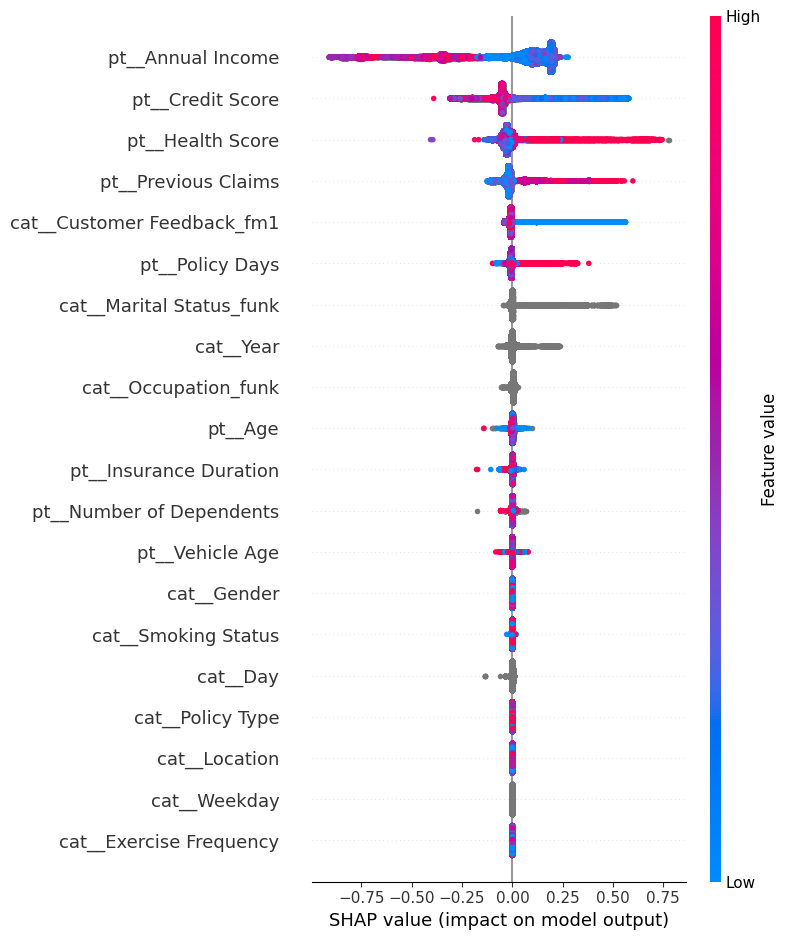

In [65]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

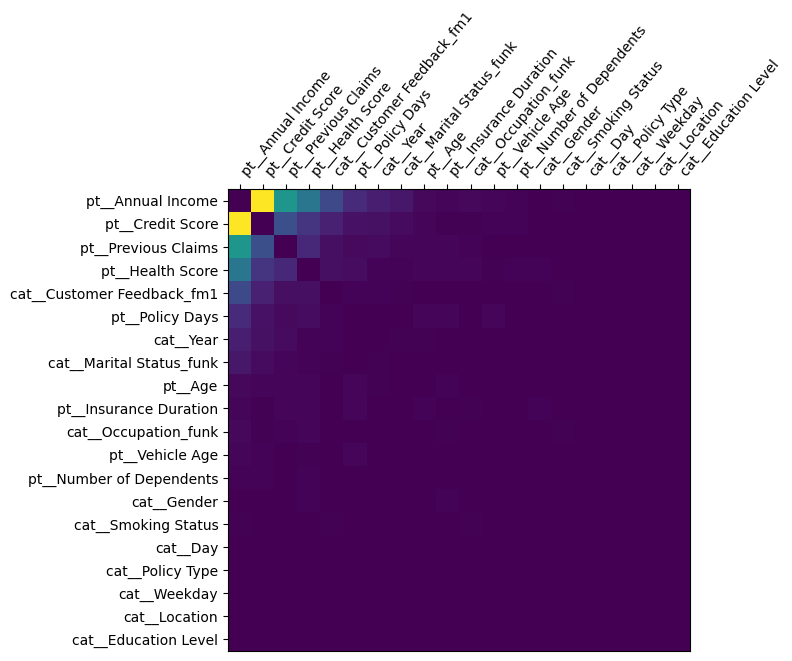

In [66]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

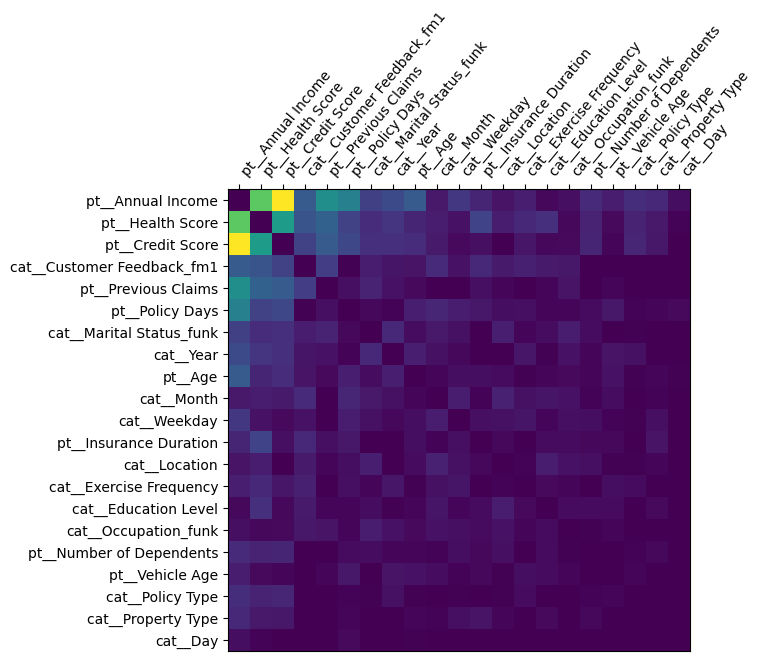

In [67]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

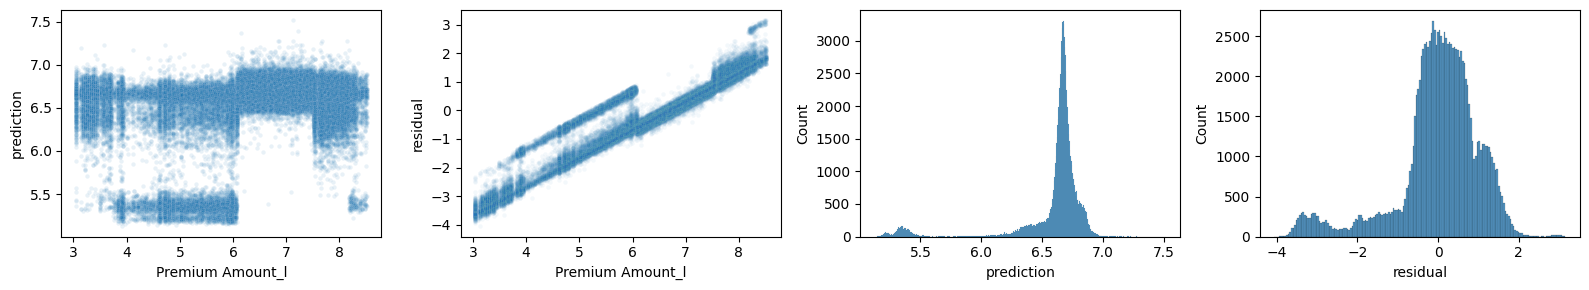

In [68]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')
sns.scatterplot(
    x = y_true, y = y_prd, alpha = 0.1, s = 10, ax=axes[0]
)
sns.scatterplot(
    x = y_true, y = residual, alpha = 0.05, s = 10, ax=axes[1]
)
sns.histplot(
    y_prd, ax = axes[2]
)
sns.histplot(
    residual, ax = axes[3]
)
plt.tight_layout()
plt.show()

target이 4와 6 사이 그리고 8 이상인 구간에서ㅓ 예측값의 분포는 6.5 와 5.4 중심으로 나뉜다는 것을 알 수 있습니다. 이 현상을 살펴 봅니다.

In [69]:
df_valid[X_ord + ['Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns =y_prd < 6.0))
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

Year  Marital Status_funk      Month  Location  \
stat    2.364787e+02         6.503205e+01  33.040586  3.767016   
pvalue  4.368169e-49         4.937458e-14   0.000518  0.152056   

        Education Level   Weekday    Gender  Smoking Status       Day  \
stat           4.906023  7.644077  0.793756        0.166094  25.53296   
pvalue         0.178809  0.265356  0.372967        0.683607   0.69874   

        Property Type  Exercise Frequency  Occupation_funk  Policy Type  \
stat         0.430001            0.766566         0.476485     0.099344   
pvalue       0.806541            0.857446         0.924026     0.951541   

        Customer Feedback  
stat             0.029353  
pvalue           0.985431

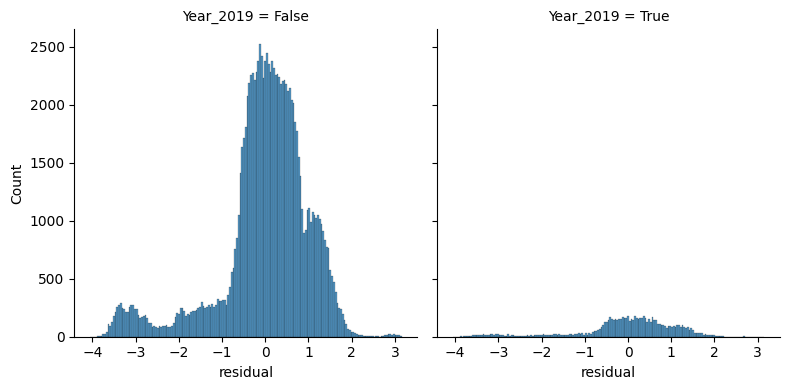

In [70]:
sns.displot(
    x=residual, col = df_valid['Year_2019'], height=4
)

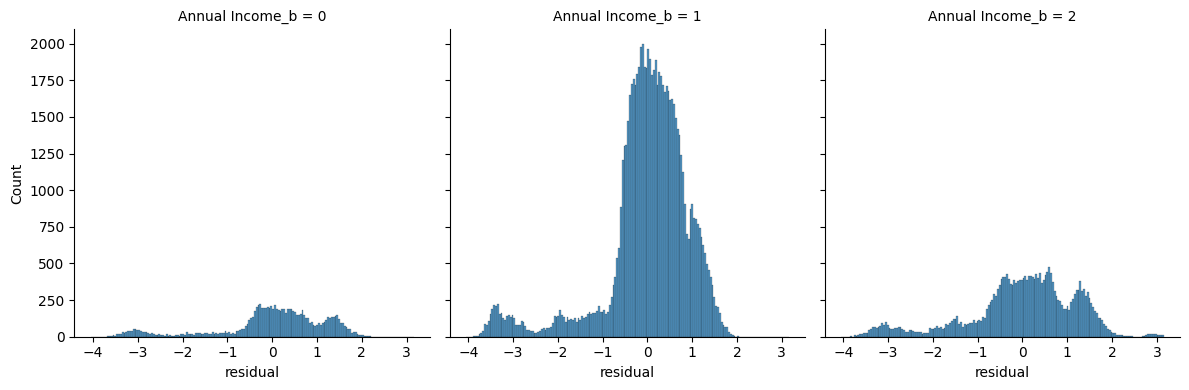

In [71]:
sns.displot(
    x=residual, col = df_valid['Annual Income_b'], height=4
)

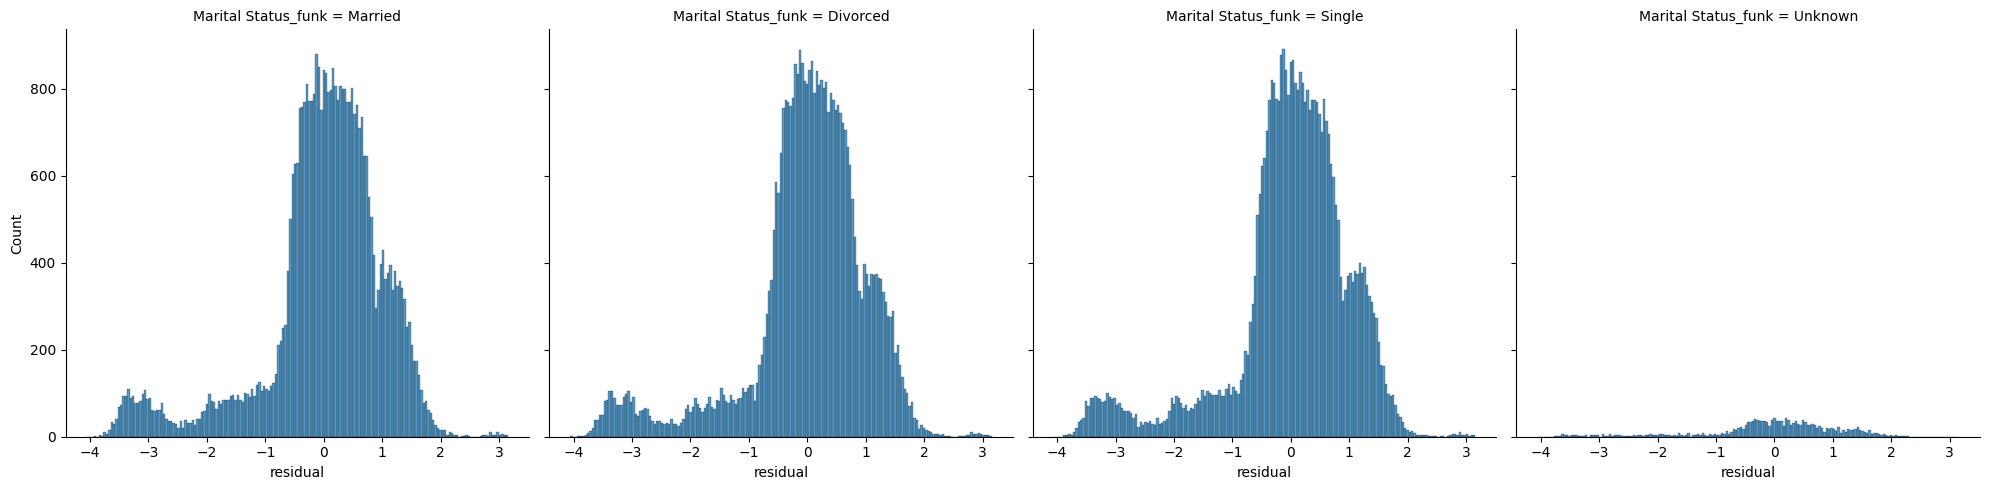

In [72]:
sns.displot(
    x=residual, col = df_valid['Marital Status_funk']
)

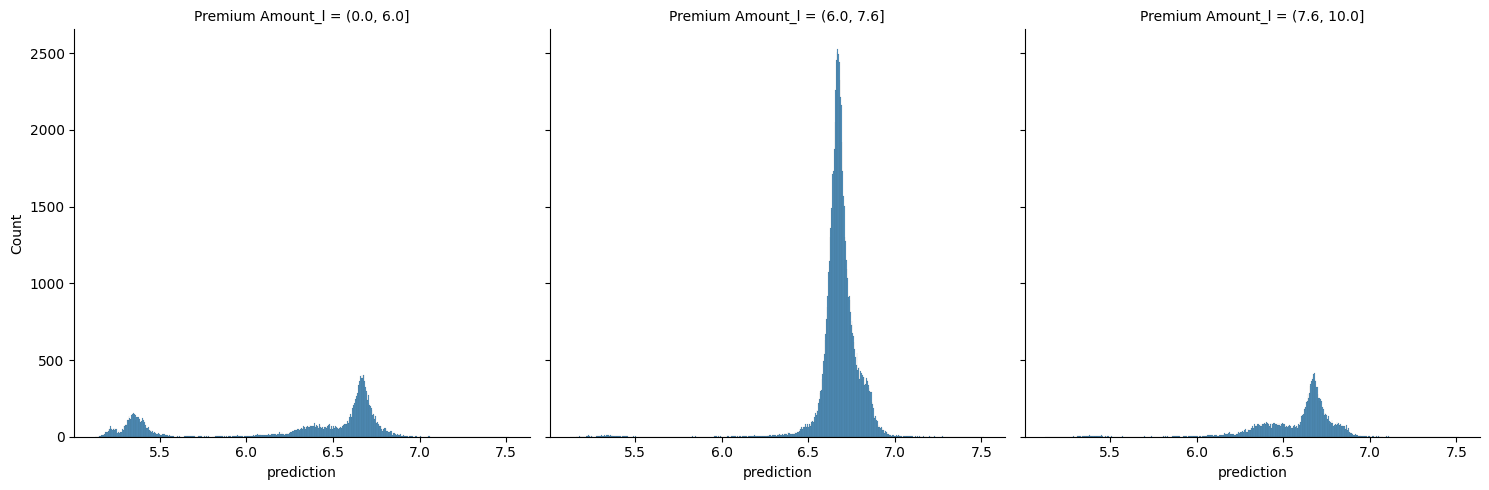

In [73]:
sns.displot(
    x=y_prd, col = pd.cut(df_valid[target], [0, 6, 7.6, 10])
)

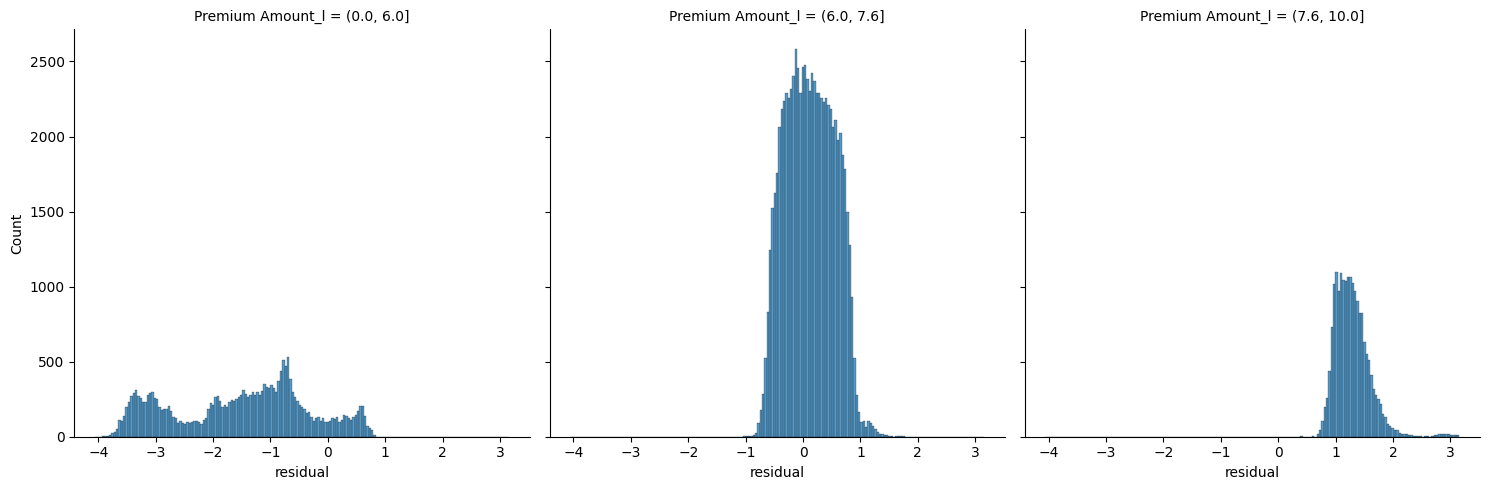

In [74]:
sns.displot(
    x=residual, col = pd.cut(df_valid[target], [0, 6, 7.6, 10])
)

target의 구간에 따라 잔차의 분포가 차이가 납니다. 잔차의 구간을 예측하는 모델을 만들어 봅니다. 

# ML org

In [75]:
df_valid[X_num].isna().apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns =y_prd < 6.0))
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

Annual Income  Health Score  Previous Claims  Credit Score       Age  \
stat       6257.15151  3.086195e+02     1.636195e+02  9.680562e+01  0.796043   
pvalue        0.00000  4.364683e-69     1.831818e-37  7.647868e-23  0.372279   

        Number of Dependents  Insurance Duration  Vehicle Age  Policy Days  
stat                0.058235                 0.0          0.0          0.0  
pvalue              0.809307                 1.0          1.0          1.0

In [76]:
from scipy.stats import mannwhitneyu
df_valid[X_num].apply(
    lambda x: mannwhitneyu(x.loc[y_prd < 6.0].dropna(), x.loc[y_prd >= 6.0].dropna())
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

Annual Income   Credit Score  Previous Claims   Policy Days  \
stat      497176192.5   3.530481e+08     1.144777e+08  3.435588e+08   
pvalue            0.0  4.332639e-299    4.568431e-214  1.138521e-12   

        Health Score   Vehicle Age  Number of Dependents           Age  \
stat    3.288954e+08  3.568682e+08          3.027872e+08  3.551334e+08   
pvalue  5.855080e-03  2.997973e-02          1.278878e-01  2.377475e-01   

        Insurance Duration  
stat          3.643577e+08  
pvalue        5.396336e-01

In [77]:
pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.000011
Annual Income           0.001174
Previous Claims         0.004242
Age                     0.125869
Number of Dependents    0.582786
Marital Status          0.894431
Customer Feedback       0.942788
Credit Score            0.973244
Occupation              0.987381
dtype: float64

Health Score의 결측 여부와 Annual Income의 결측 여부는 잔차와 관련성이 높습니다.

<Axes: xlabel='Premium Amount_l', ylabel='Count'>

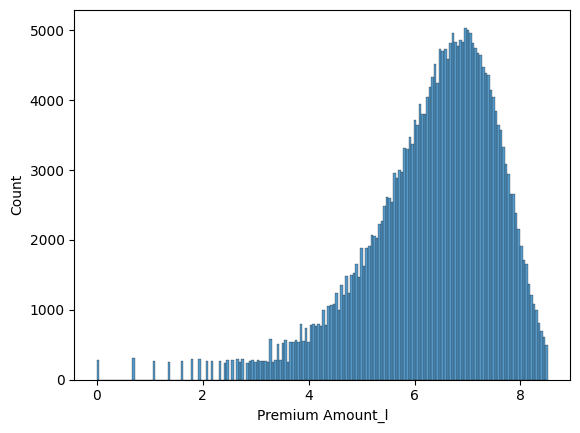

In [78]:
sns.histplot(df_org[target])

In [79]:
X_num2 = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 
         'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100, 'max_depth': 7},
    'X_num': X_num2, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_org', 
    lambda : sgml.cv(
        df_org.loc[df_org[target].notna()], ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, partial(gb_shap_learning_result, df=df_train.sample(frac=0.1)), cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

([1.2792053051935819], [1.271938380088478])

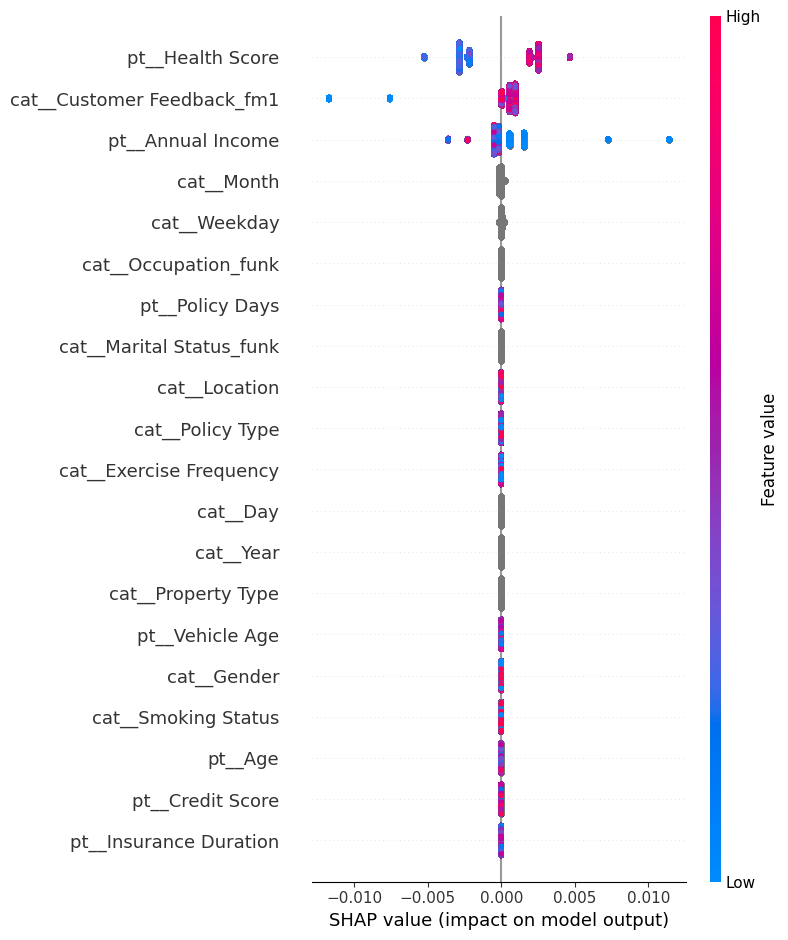

In [80]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

In [81]:
X_num2 = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 
         'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
    'X_num': X_num2, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
}
result = sc.cache_result(
    'cb_org2', 
    lambda : sgml.cv(
        df_org.loc[df_org[target].notna()], ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

([1.2792083477507088], [1.2717467316274285])

In [82]:
df_kruskal_tgt = sc.cache_result(
    'kruskal_tgt_org',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_org.groupby(i, observed=True)[target].agg(lambda x: list(x.dropna()))), index = ['stat', 'pvalue'], name = i
        )
        for i in X_bool + X_ord + X_nom
    ], axis=1), rerun = 0
)
df_kruskal_tgt.sort_values('pvalue', axis=1, ascending=True)

Education Level  Exercise Frequency  Marital Status      Month  \
stat           6.367858            5.108113        3.092418  14.307210   
pvalue         0.095022            0.164050        0.213054   0.216458   

        Smoking Status      Year   Weekday  Property Type  Customer Feedback  \
stat          1.050198  5.751461  5.665348       1.159633           1.048732   
pvalue        0.305461  0.331159  0.461702       0.560001           0.591931   

        Policy Type  Occupation  Location    Gender        Day  
stat       0.909020    0.675985  0.511081  0.013822  20.279934  
pvalue     0.634759    0.713201  0.774498  0.906412   0.909048

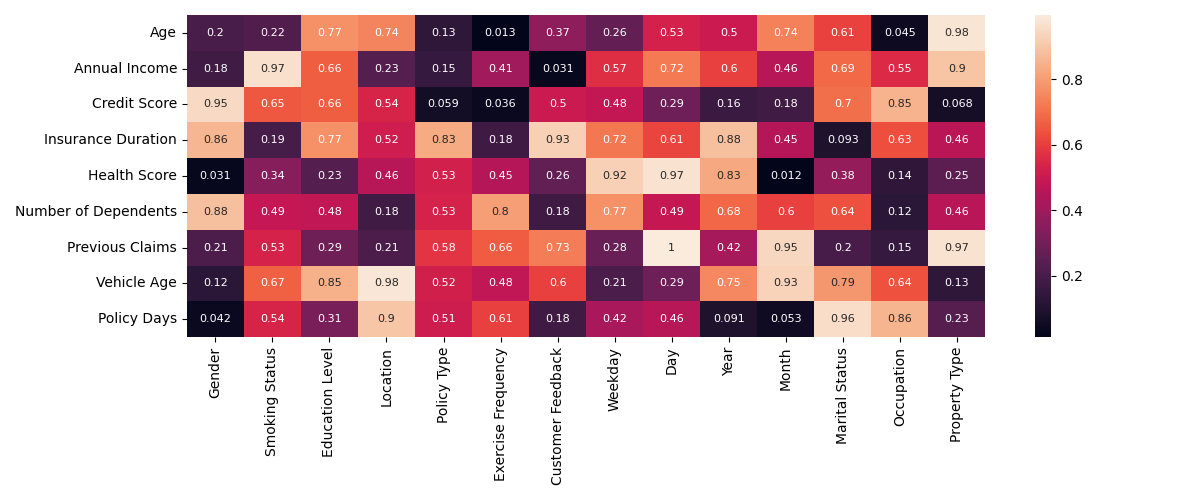

In [83]:
df_kruskal_cat_org = sc.cache_result('kruskal_cat_org', 
    lambda : pd.concat([
        df_org.groupby(df_train[i], observed=True)[X_num].agg(lambda x: x.dropna().tolist()).apply(
            lambda x: kruskal(*x).pvalue, axis=0
        ).rename(i)
        for i in X_cat
    ], axis = 1), rerun = False
)

sc.cache_fig('kruskal_cat_org',
    lambda x: sns.heatmap(
        df_kruskal_cat_org, annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (12, 5), redraw = False
)

In [84]:
df_spearman_target_org = sc.cache_result('spearman_target_org',
    lambda : pd.concat([
        pd.Series(
            df_org[[i, target]].dropna().pipe(lambda x: spearmanr(x[i], x[target])),
            index = ['stat', 'pvalue'], name = i
        )
        for i in X_num
    ], axis=1)
).sort_values('pvalue', ascending=True, axis=1)
df_spearman_target_org

Credit Score       Age  Insurance Duration  Health Score  Policy Days  \
stat        0.003484  0.003040            0.002270      0.002311     0.001480   
pvalue      0.081967  0.112657            0.232095      0.232869     0.435991   

        Number of Dependents  Previous Claims  Annual Income  Vehicle Age  
stat                0.001161        -0.001070      -0.000757     0.000212  
pvalue              0.562050         0.635471       0.697901     0.911048

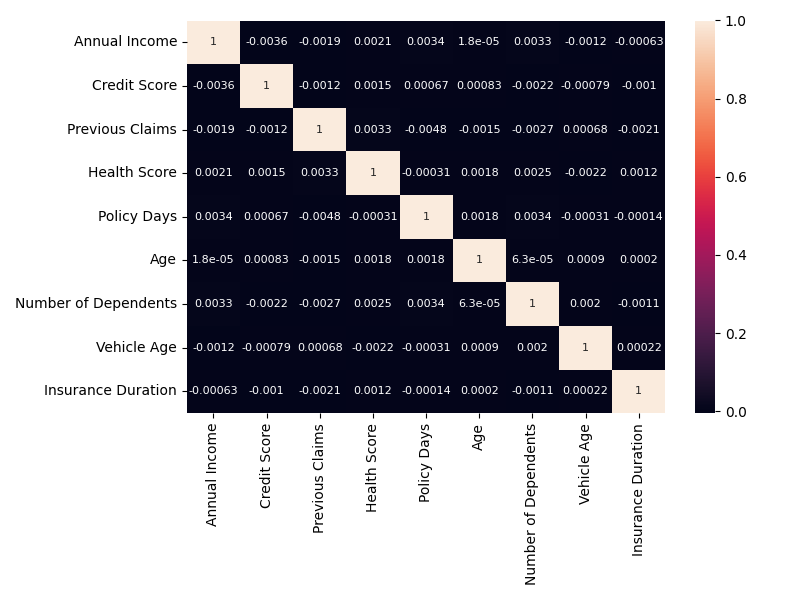

In [85]:
sc.cache_fig('spearman_between variables_org',
    lambda x: sns.heatmap(
        df_org[
            df_spearman_target_org.T['pvalue'].sort_values(ascending=True).index
        ].corr(), annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 6)
)

이 데이터셋의 기반이 되었던 원본 데이터셋을 조사해보니 ML 모델을 이용해서 Target을 예측하는 것은 의미도 없, 변수간의 상관성도 찾아볼 수 없는 

데이터셋으로 초보자가 연습삼아 만든 데이터셋으로 밖에 보이지 않습니다. 

# Missing Variable Imputation with ML

### Health Score

In [97]:
df_kruskal_cat.loc['Health Score'].sort_values().to_frame().T

Month           Day  Education Level    Gender  Location  \
Health Score  3.984273e-11  1.474154e-08         0.000002  0.000102  0.001243   

                  Year  Occupation  Property Type  Policy Type  \
Health Score  0.001639    0.005065       0.037185     0.048545   

              Exercise Frequency  Smoking Status  Marital Status  \
Health Score             0.04929        0.053193        0.104752   

              Customer Feedback   Weekday  
Health Score           0.353783  0.393192

In [98]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Health Score'].sort_values(ascending = False).iloc[1:].to_frame().T

Annual Income  Credit Score  Number of Dependents  \
Health Score        0.02553      0.012016              0.005152   

              Insurance Duration  Previous Claims  Policy Days       Age  \
Health Score            0.002487         0.001989      0.00157  0.000881   

              Vehicle Age  
Health Score     0.000316

In [165]:
from sklearn.model_selection import cross_validate

X_H_cat = ['Year', 'Month', 'Education Level', 'Gender', 'Location', 'Occupation', 'Marital_Feedback']
clf_lgb = lgb.LGBMClassifier(
    n_estimators = 500, learning_rate = 0.03,
    verbose = 0
)
sc.cache_result(
    'lgb_health_score',
    lambda :
        pd.concat([
                df_train.loc[df_train['Health Score'].notna()],
                df_test.loc[df_test['Health Score'].notna()]
            ]
        ).pipe(
            lambda x: cross_validate(
                clf_lgb, x[X_H_cat + ['Annual Income', 'Credit Score', 'Annual Income_Freq', 'Credit Score_Freq']], x['Health Score'] >= 50, scoring = 'roc_auc', cv = 5, 
                params = {'categorical_feature': X_H_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([15.70477223, 12.05882883, 12.17441678, 12.36415505, 12.21120214]),
 'score_time': array([1.45990443, 1.49009395, 1.59817076, 1.72399974, 1.60504341]),
 'test_score': array([0.69259659, 0.68911342, 0.69362903, 0.69191875, 0.6924496 ]),
 'train_score': array([0.74881153, 0.74440926, 0.74756341, 0.74677981, 0.74461675])}

In [166]:
clf_lgb = sc.cache_result(
    'lgb_health', 
    lambda : pd.concat([
                df_train.loc[df_train['Health Score'].notna()],
                df_test.loc[df_test['Health Score'].notna()]
            ]
        ).pipe(
            lambda x: clf_lgb.fit(x[X_H_cat + ['Annual Income', 'Credit Score', 'Annual Income_Freq', 'Credit Score_Freq']], x['Health Score'] >= 50)
        ), rerun = 1
)
df_train['Health Score_50'] = np.where(df_train['Health Score'] >= 50, 1.0, 0.0)
df_test['Health Score_50'] = np.where(df_test['Health Score'] >= 50, 1.0, 0.0)
df_train.loc[df_train['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
    df_train.loc[df_train['Health Score'].isna(), X_H_cat + ['Annual Income', 'Credit Score', 'Annual Income_Freq', 'Credit Score_Freq']]
)[:, 1]
df_test.loc[df_test['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
    df_test.loc[df_test['Health Score'].isna(), X_H_cat + ['Annual Income', 'Credit Score', 'Annual Income_Freq', 'Credit Score_Freq']]
)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [90]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num + ['Health Score_50'], 'X_cat': X_ord3 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result]
    ), rerun=False
)
result['valid_scores'], result['train_scores']

([1.044948133559102], [1.0420038877469961])

In [91]:
from scipy.stats import mannwhitneyu
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')

pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Previous Claims         0.001630
Health Score            0.005941
Annual Income           0.012703
Marital Status          0.163978
Number of Dependents    0.195754
Age                     0.209523
Customer Feedback       0.248595
Occupation              0.667779
Credit Score            0.787762
dtype: float64

Regression 모델로 Health Score의 예측 정확도는 기대할 수 없지만, 시각화 그래프상에서 50 이상은 뚜렷하게 분포가 차이가 남을 알 수 있고, 

이를 바탕으로 50 이상 여부를 맞추는 모델은 어느 정도 성능을 기대할 수 있어 예측 결과를 사용한 결과 성능 효과를 볼 수 있었습니다.

### Annual Income

In [172]:
df_kruskal_cat.loc['Annual Income'].sort_values().to_frame().T

Year         Month  Exercise Frequency  Policy Type  \
Annual Income  1.499166e-82  1.203363e-07            0.001482     0.187004   

               Education Level  Smoking Status    Gender       Day  \
Annual Income         0.235417        0.250826  0.271901  0.308204   

               Occupation  Customer Feedback  Property Type   Weekday  \
Annual Income    0.362187           0.419487       0.504295  0.675542   

               Location  Marital Status  
Annual Income  0.773174        0.885622

In [169]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Annual Income'].abs().sort_values(ascending = False).iloc[1:].to_frame().T

Credit Score  Previous Claims  Health Score  Policy Days  \
Annual Income      0.201423         0.043065       0.02553     0.008473   

               Number of Dependents  Vehicle Age  Insurance Duration       Age  
Annual Income              0.002135       0.0005            0.000379  0.000009

In [93]:
from sklearn.model_selection import cross_validate

X_A_cat = ['Marital_Feedback', 'Exercise Frequency', 'Year', 'Month']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.07,
    verbose = 0
)
sc.cache_result(
    'lgb_annual_income',
    lambda :
        pd.concat([
                df_train.loc[df_train['Annual Income'].notna()],
                df_test.loc[df_test['Annual Income'].notna()]
            ]
        ).pipe(
            lambda x: cross_validate(
                reg_lgb, x[X_A_cat + ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50', 'Credit Score_Freq', 'Health Score_Freq']], x['Annual Income'], 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_A_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([9.19907022, 9.22418213, 9.23747396, 9.43183923, 9.19649291]),
 'score_time': array([1.35899782, 1.41841221, 1.34676695, 1.48853564, 1.57325506]),
 'test_score': array([0.13089717, 0.13097075, 0.13044949, 0.13145334, 0.13208681]),
 'train_score': array([0.14135572, 0.14121274, 0.14148135, 0.14135071, 0.14095269])}

In [101]:
reg_lgb = sc.cache_result(
    'lgb_annual_model', 
    lambda :pd.concat([
                df_train.loc[df_train['Annual Income'].notna()],
                df_test.loc[df_test['Annual Income'].notna()]
            ]
        ).pipe(
        lambda x: reg_lgb.fit(
            x[X_A_cat + ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50', 'Credit Score_Freq', 'Health Score_Freq']], 
            x['Annual Income']
        )
    ), rerun = 1
)
df_train['Annual Income_f'] = df_train['Annual Income']
df_test['Annual Income_f'] = df_test['Annual Income']
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
    df_train.loc[df_train['Annual Income'].isna(), X_A_cat +  ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50', 'Credit Score_Freq', 'Health Score_Freq']]
).astype('int')
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
    df_test.loc[df_test['Annual Income'].isna(), X_A_cat +  ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50', 'Credit Score_Freq', 'Health Score_Freq']]
).astype('int')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [93]:
X_num2 = ['Age', 'Annual Income_isna', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age', 'Policy Days']
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num2 + ['Health Score_50', 'Annual Income_f'],
    'X_cat': X_ord3 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb3', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result]
    ), rerun=False
)
result['valid_scores'], result['train_scores']

([1.0535091062091841], [1.0516252238501083])

Annual Income은 결측여부와 함께 보간한 Annual Income을 같이 쓰면 효과가 있습니다.

In [94]:
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')

pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.001063
Previous Claims         0.006146
Annual Income           0.006218
Age                     0.168087
Number of Dependents    0.417853
Occupation              0.912206
Customer Feedback       0.947635
Credit Score            0.976443
Marital Status          0.983204
dtype: float64

## Credit Score

In [102]:
df_kruskal_cat.loc['Credit Score'].sort_values().to_frame().T

Exercise Frequency  Policy Type  Property Type      Year  \
Credit Score            0.036278     0.059011        0.06843  0.162929   

                 Month       Day   Weekday  Customer Feedback  Location  \
Credit Score  0.177985  0.292134  0.483852           0.503576  0.537244   

              Smoking Status  Education Level  Marital Status  Occupation  \
Credit Score        0.652994         0.662268        0.700621    0.851329   

                Gender  
Credit Score  0.947602

In [103]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Credit Score'].sort_values(ascending = False).iloc[1:].to_frame().T

Previous Claims  Health Score  Policy Days       Age  \
Credit Score         0.036816      0.012016     0.006817  0.002842   

              Vehicle Age  Insurance Duration  Number of Dependents  \
Credit Score     0.000508            0.000493             -0.001714   

              Annual Income  
Credit Score      -0.201423

In [105]:
from sklearn.model_selection import cross_validate

X_C_cat = ['Marital Status_funk', 'Education Level', 'Year', 'Month']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.07,
    verbose = 0
)
sc.cache_result(
    'lgb_credit_score',
    lambda :
        pd.concat([
                df_train.loc[df_train['Credit Score'].notna()],
                df_test.loc[df_test['Credit Score'].notna()]
            ]
        ).pipe(
            lambda x: cross_validate(
                reg_lgb, 
                x[X_C_cat + ['Previous Claims', 'Health Score', 'Annual Income', 'Annual Income_f', 'Health Score_50', 'Annual Income_Freq', 'Health Score_Freq']], 
                x['Credit Score'], 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_C_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([ 9.6389544 , 10.55482483,  9.914186  , 11.33128977,  9.51980686]),
 'score_time': array([1.41480279, 1.43967009, 1.67776132, 1.66745305, 1.55960298]),
 'test_score': array([0.16058741, 0.16133632, 0.16174305, 0.16200009, 0.16081609]),
 'train_score': array([0.1688999 , 0.16879708, 0.16878153, 0.16884502, 0.1689604 ])}

In [111]:
reg_lgb = sc.cache_result(
    'lgb_credit_score_prd', 
    lambda :pd.concat([
            df_train.loc[df_train['Credit Score'].notna()],
            df_test.loc[df_test['Credit Score'].notna()]
        ]
    ).pipe(
        lambda x: reg_lgb.fit(x[X_C_cat + ['Previous Claims', 'Health Score', 'Annual Income', 'Annual Income_f', 'Health Score_50', 'Annual Income_Freq', 'Health Score_Freq']], x['Credit Score'])
    ), rerun = 0
)
df_train['Credit Score_f'] = df_train['Credit Score']
df_test['Credit Score_f'] = df_test['Credit Score']
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score_f'] = reg_lgb.predict(
    df_train.loc[df_train['Credit Score'].isna(), X_C_cat + ['Previous Claims', 'Health Score', 'Annual Income', 'Annual Income_f', 'Health Score_50', 'Annual Income_Freq', 'Health Score_Freq']]
).astype('int')
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score_f'] = reg_lgb.predict(
    df_test.loc[df_test['Credit Score'].isna(), X_C_cat + ['Previous Claims', 'Health Score', 'Annual Income', 'Annual Income_f', 'Health Score_50', 'Annual Income_Freq', 'Health Score_Freq']]
).astype('int')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


## Previous Claims

In [124]:
df_kruskal_cat.loc['Previous Claims'].sort_values().to_frame().T

Year  Policy Type  Property Type   Weekday       Day  \
Previous Claims  5.431242e-17     0.020671        0.03072  0.035647  0.041818   

                 Customer Feedback  Education Level     Month  Marital Status  \
Previous Claims           0.046106         0.056846  0.077654        0.086356   

                 Smoking Status  Location  Exercise Frequency    Gender  \
Previous Claims        0.086622  0.321809            0.375611  0.882875   

                 Occupation  
Previous Claims    0.946917

In [125]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Previous Claims'].sort_values(ascending = False).iloc[1:].to_frame().T

Annual Income  Credit Score  Insurance Duration  \
Previous Claims       0.043065      0.036816            0.002999   

                 Health Score       Age  Vehicle Age  Number of Dependents  \
Previous Claims      0.001989  0.001869    -0.001172             -0.004123   

                 Policy Days  
Previous Claims    -0.006132

In [158]:
from sklearn.model_selection import cross_validate

X_PC_cat = ['Year', 'Policy Type', 'Property Type', 'Marital_Feedback', 'Weekday']
X_PC_num = ['Credit Score', 'Credit Score_f','Annual Income', 'Annual Income_f', 'Annual Income_Freq', 
            'Credit Score_Freq', 'Health Score_Freq', 'Health Score', 'Health Score_50']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.07,
    verbose = 0
)
sc.cache_result(
    'lgb_previous_claims',
    lambda :
        pd.concat([
            df_train.loc[df_train['Previous Claims'].notna()],
            df_test.loc[df_test['Previous Claims'].notna()]
        ]).pipe(
            lambda x: cross_validate(
                reg_lgb, 
                x[X_PC_cat + X_PC_num], 
                x['Previous Claims'].clip(0, 6), 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_PC_cat}, return_train_score = True
            )
        )
    , rerun = 0
)

{'fit_time': array([8.11343431, 7.90257287, 8.3236897 , 9.07603836, 8.19751048]),
 'score_time': array([1.09506154, 1.06434655, 1.06192708, 1.18009067, 1.15176845]),
 'test_score': array([0.09760106, 0.09852946, 0.09823809, 0.09745972, 0.09675327]),
 'train_score': array([0.10942475, 0.10941761, 0.11007139, 0.10939971, 0.10914   ])}

In [160]:
reg_lgb = sc.cache_result(
    'lgb_previous_claims_model', 
    lambda :pd.concat([
            df_train.loc[df_train['Previous Claims'].notna()],
            df_test.loc[df_test['Previous Claims'].notna()]
    ]).pipe(
        lambda x: reg_lgb.fit(x[X_PC_cat + X_PC_num],  x['Previous Claims'].clip(0, 6))
    ), rerun = 0
)
df_train['Previous Claims_f'] = df_train['Previous Claims']
df_test['Previous Claims_f'] = df_test['Previous Claims']
df_train.loc[df_train['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
    df_train.loc[df_train['Previous Claims'].isna(), X_PC_cat +  X_PC_num]
).astype('float32')
df_train['Previous Claims_f'] = df_train['Previous Claims_f']
df_test.loc[df_test['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
    df_test.loc[df_test['Previous Claims'].isna(), X_PC_cat + X_PC_num]
).astype('float32')
df_test['Previous Claims_f'] = df_test['Previous Claims_f']

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


# ML Previous Claims

In [205]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config_3 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index=df.index),
    'score_func': lambda df, prds: r2_score(df['Previous Claims'].sort_index(), prds.sort_index()) ** 0.5,
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': 'Previous Claims',
}

lgb_adapter =  sgml.LGBAdapter(cb.LGBMRegressor)

In [206]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration', 'Number of Dependents_fz']
X_C_cat = ['Occupation_funk', 'Property Type', 'Marital_Feedback'] + X_bool
X_C_num = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Vehicle Age', 'Policy Days'] + \
        ['Annual Income_Freqz','Credit Score_Freqz', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f', 
        'CA_C', 'CA_A', 'AH_H', 'CH_H']
hparams = {
    'model_params': {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05},
    'X_num': X_C_num, 
    'X_cat': X_ord3 + X_C_cat, 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_pc', 
    lambda : sgml.cv(
        df_train.loc[df_train['Previous Claims'].notna()], ss, hparams, config_3, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=1
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/200 [00:00<?, ?it/s]

([0.2957004000548975], [0.3067247253815122])

In [207]:
result['model_result'][0]['feature_importance'].sort_values(ascending=False).iloc[:15]

pt__Annual Income_f        23.327716
pt__Credit Score_f         21.962877
pt__Annual Income           9.073877
pt__Credit Score            7.661707
cat__Marital_Feedback       5.733729
pt__Credit Score_Freqz      5.130436
pt__AH_H                    5.006127
pt__Health Score_50         3.675144
pt__CA_A                    3.615252
cat__Year                   3.060617
pt__Annual Income_Freqz     2.509320
pt__Health Score            2.044380
pt__Health Score_Freq       1.758664
pt__Policy Days             1.228517
pt__CA_C                    1.128032
dtype: float64

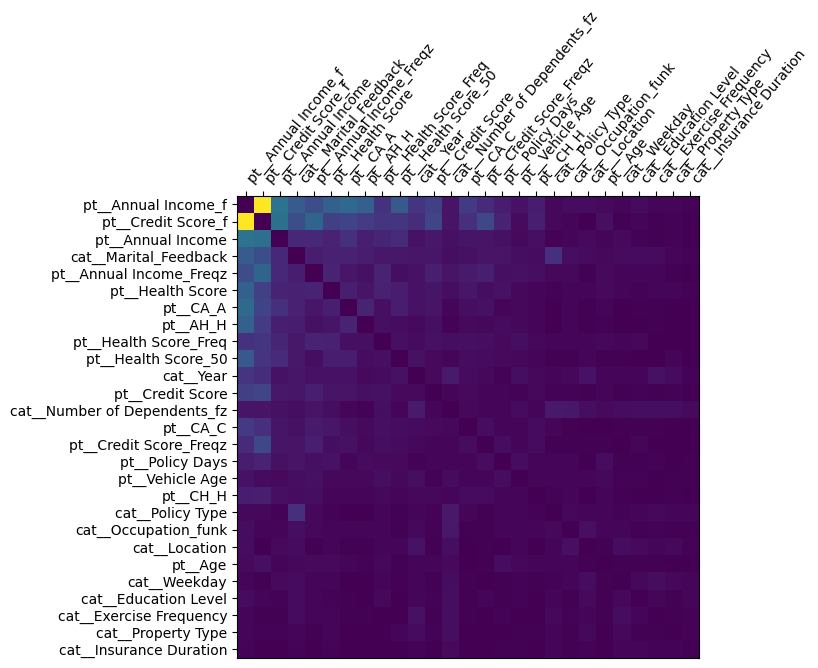

In [208]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.show()

# Using Classification

In [119]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

df_train['target_3'] =  pd.cut(df_train[target], [-np.inf, 6, 7.6, np.inf], labels = [0, 1, 2])
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config_2 = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index),
    'score_func': lambda df, prds: accuracy_score(df['target_3'].sort_index(), prds.idxmax(axis=1).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': 'target_3',
}

cb_adapter_c = sgml.CBAdapter(cb.CatBoostClassifier)
lr_adapter_c = sgml.SklearnAdapter(LogisticRegression)

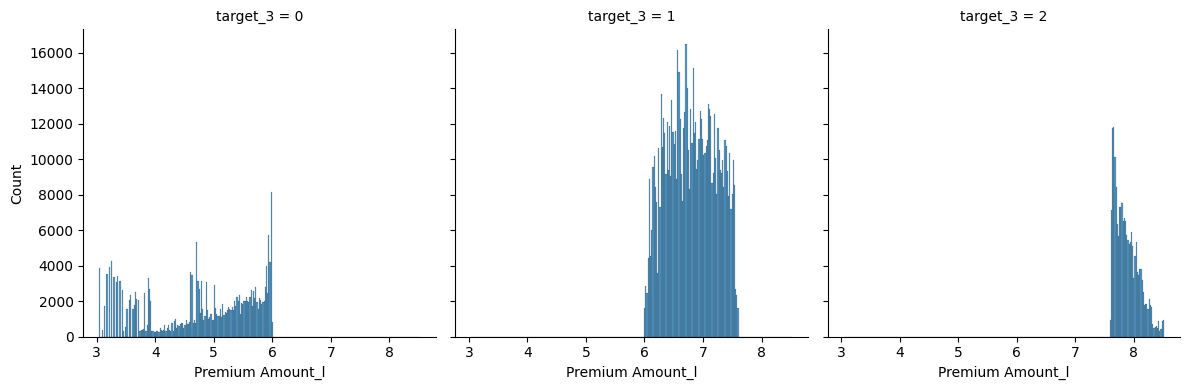

In [120]:
sns.displot(x = df_train[target], col = df_train['target_3'], height=4)

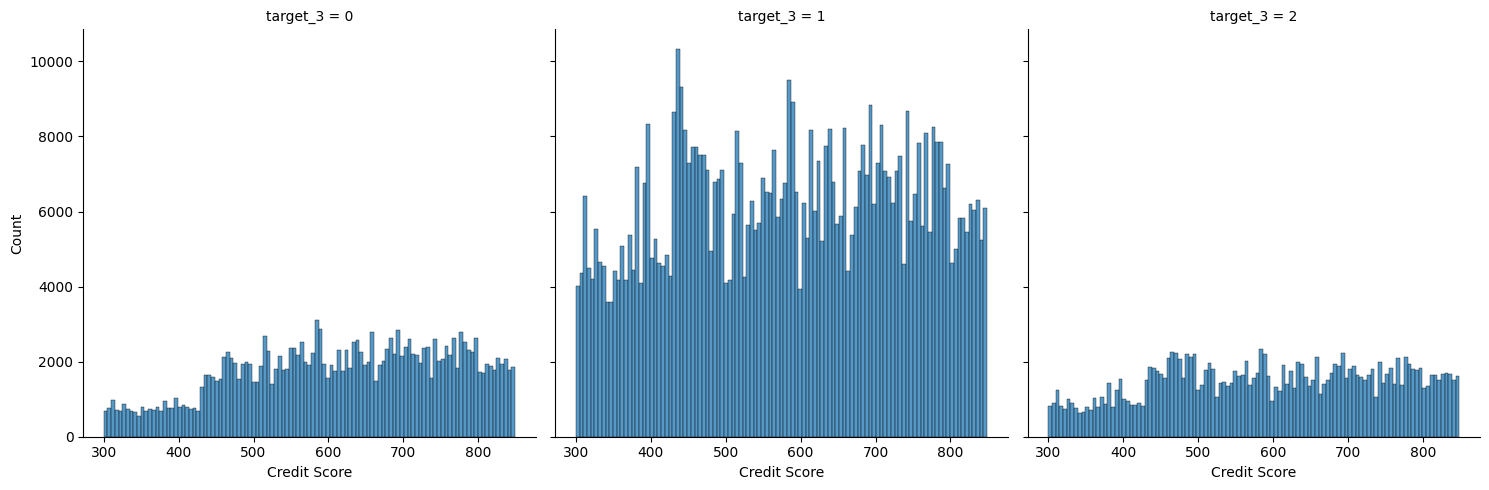

In [121]:
sns.displot(df_train, x = 'Credit Score' , col = 'target_3')

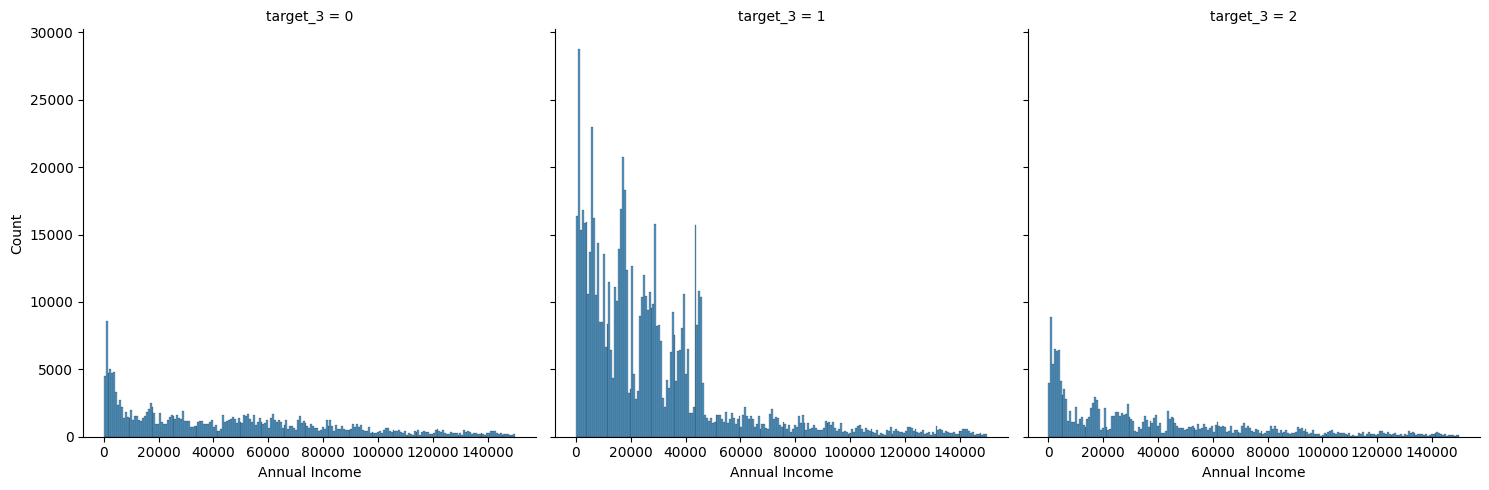

In [122]:
sns.displot(df_train, x = 'Annual Income' , col = 'target_3')

In [204]:
df_train['Annual Income_qm'] = pd.cut(df_train['Annual Income'], bins = 25)
df_train['Credit Score_qm'] = pd.cut(df_train['Credit Score'],  bins = 10)
df_train['Health Score_qm'] = pd.cut(df_train['Health Score'], bins = 5)

ctype = pd.CategoricalDtype(['NA'] + df_train['Credit Score_qm'].cat.categories.tolist())
df_train['Credit Score_qm'] = dproc.replace_cat(df_train['Credit Score_qm'].astype(ctype).fillna('NA'), lambda x: str(x))
ctype = pd.CategoricalDtype(['NA'] + df_train['Annual Income_qm'].cat.categories.tolist())
df_train['Annual Income_qm'] = dproc.replace_cat(df_train['Annual Income_qm'].astype(ctype).fillna('NA'), lambda x: str(x))
ctype = pd.CategoricalDtype(['NA'] + df_train['Health Score_qm'].cat.categories.tolist())
df_train['Health Score_qm'] = dproc.replace_cat(df_train['Health Score_qm'].astype(ctype).fillna('NA'), lambda x: str(x))

df_train['CA'] = dproc.combine_cat(df_train[['Annual Income_qm', 'Credit Score_qm']], '_')
df_train['AH'] = dproc.combine_cat(df_train[['Annual Income_qm', 'Health Score_qm']], '_')
df_train['CH'] = dproc.combine_cat(df_train[['Credit Score_qm', 'Health Score_qm']], '_')
df_train['ACH'] = dproc.combine_cat(df_train[['Annual Income_qm', 'Credit Score_qm', 'Health Score_qm']], '_')

from sklearn.preprocessing import TargetEncoder
val = ['ACH', 'AH', 'CA', 'CH', 'Credit Score_qm', 'Annual Income_qm', 'Health Score_qm']
kf_dic = {i: list() for i in val}
tgt = TargetEncoder()
for train_idx, test_idx in kf.split(df_train, df_train[target]):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
    for i in val:
        tgt.fit(df_cv_train[[i]], df_cv_train[target])
        #print(i, mean_squared_error(df_valid[target], tgt.transform(df_valid[[i]]))  ** 0.5)
        kf_dic[i].append(
            pd.Series(tgt.transform(df_valid[[i]])[:, 0], index = df_valid.index, name = i)
        )

df_tmp = pd.concat([pd.concat(v, axis=0) for k, v in kf_dic.items()], axis=1)
df_train['CA_C'] = df_tmp['CA'] - df_tmp['Credit Score_qm']
df_train['CA_A'] = df_tmp['CA'] - df_tmp['Annual Income_qm']
df_train['AH_A'] = df_tmp['AH'] - df_tmp['Annual Income_qm']
df_train['AH_H'] = df_tmp['AH'] - df_tmp['Health Score_qm']
df_train['CH_H'] = df_tmp['CH'] - df_tmp['Health Score_qm']
df_train['CH_C'] = df_tmp['CH'] - df_tmp['Credit Score_qm']

df_train['ACH_tgt'] = df_tmp['ACH']
df_train['CH_tgt'] = df_tmp['CH']
df_train['AH_tgt'] = df_tmp['AH']
df_train['CA_tgt'] = df_tmp['CA']

df_train['Insurance Duration'] = df_train['Insurance Duration'].fillna(df_train['Insurance Duration'].mode()[0]).astype('int')

In [118]:
tgt = TargetEncoder()
val = 'ACH'
l = list()
for train_idx, test_idx in kf.split(df_train, df_train[target]):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
    tgt.fit(df_cv_train[[val]], df_cv_train['target_3'])
    l.append(
        pd.DataFrame(tgt.transform(df_valid[[val]]), index = df_valid.index)
    )
X_c = ['ACH_{}'.format(i) for i in range(3)]
df_train[X_c] = pd.concat(l, axis=0).rename(columns = lambda x: '{}_{}'.format(val, x))

In [168]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05},
    'X_num':  X_num3 + ['Annual Income_Freqz','Credit Score_Freqz', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f'], 
    'X_cat': X_ord3 + ['Occupation_funk', 'Property Type', 'Marital_Feedback'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_c', 
    lambda : sgml.cv(
        df_train, ss, hparams, config_2, cb_adapter_c, 
        result_proc = [sgml.cb_learning_result,  cb_interaction_importance]
    ), rerun=1
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/200 [00:00<?, ?it/s]

([0.7429916666666667], [0.7417305555555556])

In [169]:
df_train['target_3'].value_counts(normalize=True)

target_3
1    0.653996
0    0.188366
2    0.157638
Name: proportion, dtype: float64

In [170]:
result['model_result'][0]['feature_importance'].sort_values(ascending=False).iloc[:15]

pt__CA_C                   10.408469
pt__Annual Income_f        10.227415
cat__Marital_Feedback       9.396860
pt__Annual Income           9.277691
pt__Previous Claims_fm1     8.124103
pt__Previous Claims_f       7.410387
pt__Health Score_50         7.276226
pt__CA_A                    6.466120
pt__Credit Score_f          6.389349
pt__Annual Income_Freqz     5.594696
pt__AH_H                    4.101392
pt__CH_H                    3.864581
pt__Health Score            2.915225
pt__Policy Days             2.304299
pt__Health Score_Freq       2.167801
dtype: float64

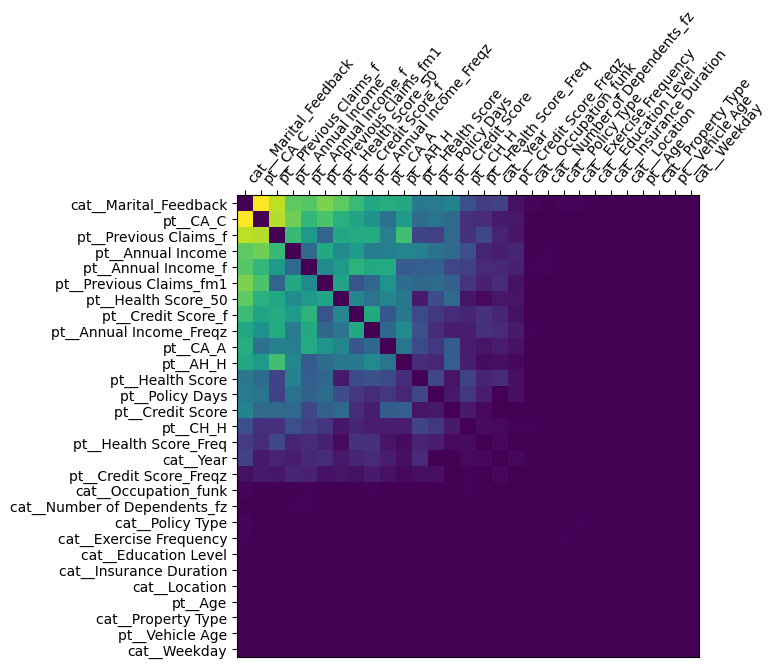

In [171]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.show()

In [167]:
hparams = {
    'X_mm': ['Previous Claims_fm1', 'Credit Score_fz', 'Health Score_fz', 'Annual Income_fz', 'Age_fz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_fz', 'Annual Income_Freqz','Credit Score_Freqz', 
              'CA_tgt', 'AH_tgt', 'CH_tgt', 'ACH_tgt'] + X_c,
    'X_ohe': ['Customer Feedback_fm1'], 'ohe': {'drop': 'first'},
}
sgml.cv(df_train, ss, hparams, config, lr_adapter)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

{'valid_scores': [1.070005023494801],
 'valid_prd': id
 319351     6.737682
 604239     6.594522
 200654     6.573201
 452912     6.623806
 721610     5.843849
              ...   
 270080     6.866488
 640185     6.688718
 1035776    6.589426
 1053882    6.783679
 714747     5.954183
 Length: 120000, dtype: float64,
 'model_result': [],
 'train_scores': [1.0697804079831994]}

In [161]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05},
    'X_num': X_num3 + ['Annual Income_Freqz','Credit Score_Freqz', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f',
                       'CA_C', 'CA_A', 'AH_H', 'CH_H', 'Previous Claims_f'], 
    'X_cat': X_ord3 + ['Occupation_funk', 'Property Type', 'Marital_Feedback'] + X_bool, # 'Customer Feedback_fm1', 'Marital Status_funk', 
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=1
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/200 [00:00<?, ?it/s]

([1.0449227312364602], [1.0417381022975283])

In [162]:
result['model_result'][0]['feature_importance'].sort_values(ascending = False).iloc[:20]

cat__Marital_Feedback      11.671507
pt__Previous Claims_f      11.580383
pt__CA_C                   10.076255
pt__Health Score_50         9.459003
pt__Previous Claims_fm1     7.748983
pt__AH_H                    5.990398
pt__Policy Days             5.747150
pt__CA_A                    5.697300
pt__Annual Income           5.390962
pt__Annual Income_f         5.067687
pt__Annual Income_Freqz     4.175672
pt__Credit Score_f          3.262778
pt__CH_H                    2.630887
pt__Health Score_Freq       2.300371
cat__Year                   2.157203
pt__Health Score            1.556051
pt__Credit Score            1.526766
pt__Credit Score_Freqz      0.866693
cat__Occupation_funk        0.845638
pt__Age                     0.645013
dtype: float64

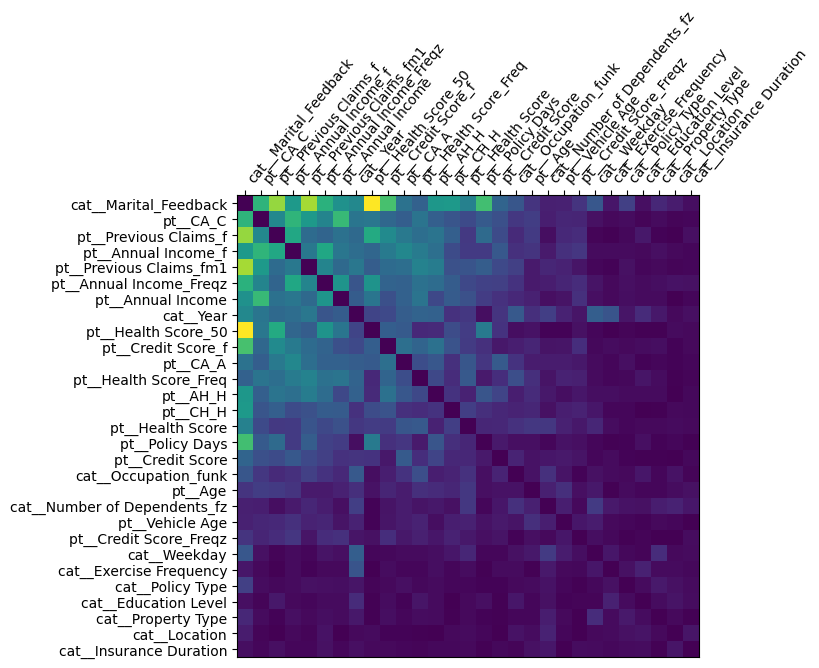

In [163]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.show()

In [129]:
df_train['Marital_Feedback'] = dproc.combine_cat(df_train[['Marital Status_funk', 'Customer Feedback_fm1']].assign(
    CF_cat = lambda x: x['Customer Feedback_fm1'].astype('category')
).drop(columns = ['Customer Feedback_fm1']), '_')

df_test['Marital_Feedback'] = dproc.combine_cat(df_test[['Marital Status_funk', 'Customer Feedback_fm1']].assign(
    CF_cat = lambda x: x['Customer Feedback_fm1'].astype('category')
).drop(columns = ['Customer Feedback_fm1']), '_')

In [145]:
df_train.loc[df_train['Previous Claims'].notna()].pipe(
    lambda x: chi2_contingency(
        pd.crosstab(index = dproc.combine_cat(
            x[['Marital Status_funk', 'Customer Feedback_fm1']].assign(
                CF_cat = lambda x: x['Customer Feedback_fm1'].astype('category')
            ).drop(columns = ['Customer Feedback_fm1']), '_'),
            columns = x['Previous Claims_fm1'].clip(-1, 6)
        )
    )[:2]
)

(370.9349849834329, 8.878708349601731e-36)